In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import burst_detector as bd
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.profiler import profile, record_function, ProfilerActivity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy.spatial.distance as dist
import distinctipy

In [2]:
n_chan = 385

ks_dir = r"C:\Users\Harris_Lab\Projects\burst-detector\data\rec_bank0_dense_g0\KS2.5\catgt_rec_bank0_dense_g0\rec_bank0_dense_g0_imec0\imec0_ks2"

times = np.load(os.path.join(ks_dir, "spike_times.npy")).flatten()
clusters = np.load(os.path.join(ks_dir, "spike_clusters.npy")).flatten()

counts = bd.spikes_per_cluster(clusters)
cl_labels = pd.read_csv(os.path.join(ks_dir, "cluster_group.tsv"), sep="\t", index_col=False)
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))

channel_pos = np.load(os.path.join(ks_dir, "channel_positions.npy"))
channel_map = np.load(os.path.join(ks_dir, "channel_map.npy")).flatten()
mean_wf = np.load(os.path.join(ks_dir, "mean_waveforms.npy"))
peak_chans = np.argmax(np.max(mean_wf, 2) - np.min(mean_wf,2),1)

channel_shanks = (channel_pos[:,0]/250).astype("int")
templates = np.load(os.path.join(ks_dir, "templates.npy"))

# load raw data
rawData = np.memmap(r"C:\Users\Harris_Lab\Projects\burst-detector\data\rec_bank0_dense_g0\KS2.5\catgt_rec_bank0_dense_g0\rec_bank0_dense_g0_imec0\rec_bank0_dense_g0_tcat.imec0.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [3]:
params = {}

params["data_filepath"] = r"C:\Users\Harris_Lab\Projects\burst-detector\data\rec_bank0_dense_g0\KS2.5\catgt_rec_bank0_dense_g0\rec_bank0_dense_g0_imec0\rec_bank0_dense_g0_tcat.imec0.ap.bin"
params["KS_folder"] =  ks_dir

params["calc_means"] = False
params["fs"] = 30000
params["n_chan"] = 385
params["pre_samples"] = 20
params["post_samples"] = 62
params["max_spikes"] = 1000

params["skip_cross_sim"] = False

params["jitter"] = False
params["jitter_amt"] = 4
params["sim_thresh"] = 0.4
params["min_spikes"] = 100

params["n_iter"] = 50
params["shuffle_bin_width"] = 0.1
params["window_size"] = 0.025
params["xcorr_bin_width"] = 0.0005
params["overlap_tol"] = 10/30000
params["max_window"] = 0.25
params["min_xcorr_rate"] = 800

params["xcorr_ref_p"] = 0.001
params["ref_pers"] = [0.001, 0.002, 0.004]
params["max_viol"] = 0.25

params["xcorr_coeff"] =  0.5
params["ref_pen_coeff"] = 1
params["final_thresh"] = 0.5
params["max_dist"] = 10

params['ae_pre'] = 10
params['ae_post'] = 30
params['ae_chan'] = 8
params['ae_noise'] = False
params['ae_shft'] = False

In [4]:
n_clust = clusters.max() + 1
cl_good = np.zeros(n_clust, dtype=bool)
unique = np.unique(clusters)
for i in range(n_clust):
     if (i in unique) and (counts[i] > params['min_spikes']) \
        and (cl_labels.loc[cl_labels['cluster_id']==i, 'group'].item() == 'good'):
            cl_good[i] = True

In [156]:
mean_wf = np.zeros(
            (n_clust, 
             params['n_chan'],
             params['pre_samples'] + params['post_samples'])
        ) 
std_wf = np.zeros(
            (n_clust, 
             params['n_chan'],
             params['pre_samples'] + params['post_samples'])
        ) 
spikes = {}
for i in range(n_clust):
    if cl_good[i]:
        spikes[i] = bd.extract_spikes(
            data, times_multi, clusters, i,
            n_chan=params['n_chan'],
            pre_samples=params['pre_samples'],
            post_samples=params['post_samples'],
            max_spikes=params['max_spikes']
        )
        mean_wf[i,:,:] = np.nanmean(spikes[i], axis=0)
        std_wf[i,:,:] = np.nanstd(spikes[i], axis=0)
peak_chans = np.argmax(np.max(mean_wf, 2) - np.min(mean_wf,2),1)

In [6]:
chans = {}

for i in range(mean_wf.shape[0]):
    if i in counts:
        chs, peak = bd.utils.find_best_channels(mean_wf[i], channel_pos, params['ae_chan'])
        dists = bd.utils.get_dists(channel_pos, peak, chs)
        chans[i] = chs[np.argsort(dists)].tolist()

In [24]:
spk_fld = os.path.join(params['KS_folder'], "automerge", "spikes")
# ci = {'times': times,
#     'times_multi': times_multi,
#     'clusters': clusters,
#     'counts': counts,
#     'labels': cl_labels,
#     'mean_wf': mean_wf
# }
# gti = {
#     'spk_fld': spk_fld,
#     'pre_samples': params['ae_pre'],
#     'post_samples': params['ae_post'],
#     'num_chan': params['ae_chan'],
#     'noise': params['ae_noise'],
#     'for_shft': params['ae_shft']
# }
# bd.generate_train_data(data, ci, channel_pos, gti, params)

In [382]:
net, spk_data = bd.train_ae(spk_fld, counts, do_shft=params['ae_shft'], num_epochs=5)

EPOCH 1/5
Training batch 500/581 Batch 499 | loss: 857.4274
Training batch 581/581
Testing batch 146/146
LOSS | train: 528.9429 | test 495.0500
EPOCH 2/5
Training batch 500/581 Batch 499 | loss: 463.9501
Training batch 581/581
Testing batch 146/146
LOSS | train: 413.1133 | test 395.0780
EPOCH 3/5
Training batch 500/581 Batch 499 | loss: 392.5436
Training batch 581/581
Testing batch 146/146
LOSS | train: 369.6095 | test 359.1305
EPOCH 4/5
Training batch 500/581 Batch 499 | loss: 366.0331
Training batch 581/581
Testing batch 146/146
LOSS | train: 362.2724 | test 406.2745
EPOCH 5/5
Training batch 500/581 Batch 499 | loss: 352.3615
Training batch 581/581
Testing batch 146/146
LOSS | train: 355.0066 | test 360.4123


In [516]:
torch.save(net.state_dict(), './models/hippo_vn_15d.pt')

In [7]:
spk_fld = os.path.join(params['KS_folder'], "automerge", "spikes")
spk_data = bd.autoencoder.SpikeDataset(os.path.join(spk_fld, "labels.csv"),spk_fld, ToTensor())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = bd.autoencoder.CN_AE().to(device)
net.load_state_dict(torch.load('./models/bijan_vn_15d.pt'))
net.eval();

In [8]:
BATCH_SIZE = 1024
labels = spk_data.spk_labels.iloc[:, 1]

dl = DataLoader(spk_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imgs, lab = next(iter(dl))
imgs = imgs[:,:,:,:].to(device)
out1 = net(imgs).squeeze().cpu().detach().numpy()
imgs = imgs.squeeze().cpu().detach().numpy()

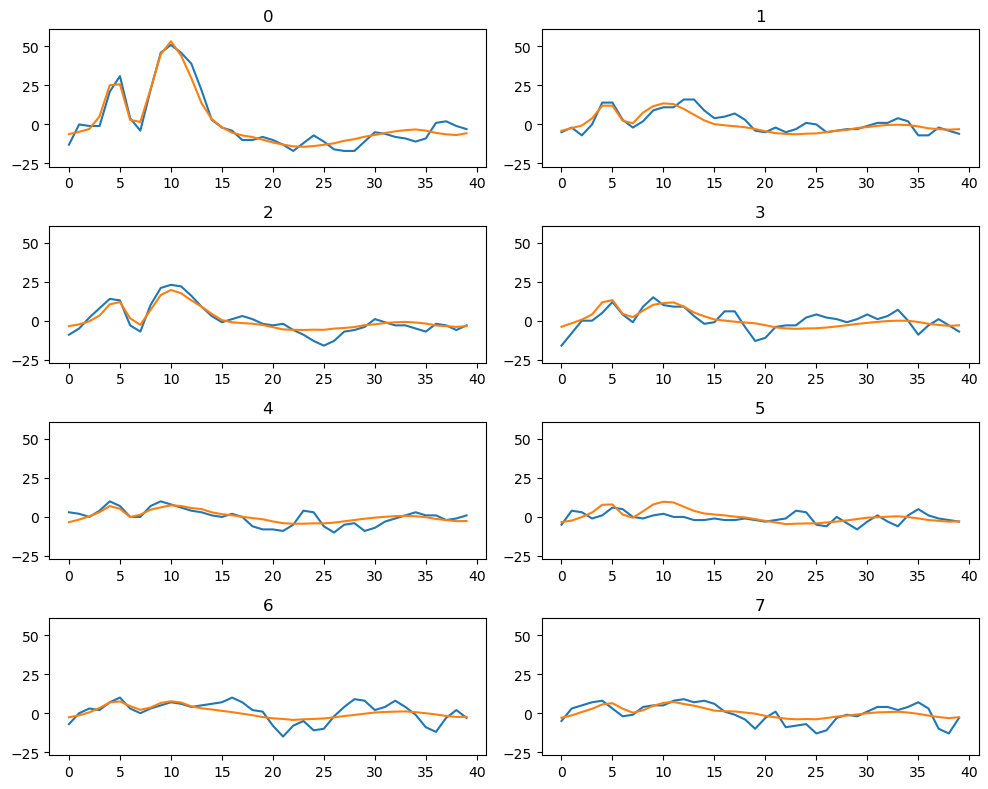

In [559]:
idx = 923
cl = int(lab[idx])
# ch_cl = chans[cl]
plt.figure(figsize=(10,8))

for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(imgs[idx, i])
    plt.plot(out1[idx, i])
    # plt.plot(out2[idx, i])
    # plt.plot(mean_wf[cl,ch_cl[i],10:50])
    plt.title(i); plt.ylim(imgs[idx,:].min()-10, imgs[idx,:].max()+10)
    
plt.tight_layout()
# plt.savefig("../figures/paper/ae_recon.svg", transparent=True)

In [10]:
chans[-1] = [-1]
ae_sim, spk_lat_peak, lat_mean, spk_lab = bd.stages.calc_ae_sim(mean_wf, net, peak_chans, spk_data, chans, cl_good, do_shft=False, sf=5)

Calculating latent features...
Batch 1567/1567
LOSS: 24.850979179961712


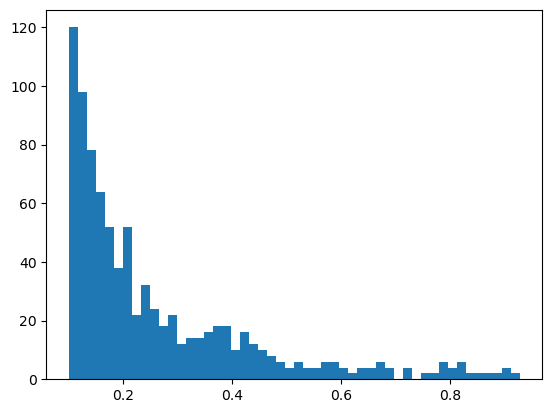

In [11]:
plt.hist(ae_sim.flatten()[ae_sim.flatten() > .1], bins=50);

In [12]:
lat_dist = np.vstack((spk_lat_peak, lat_mean))

In [13]:
ae_df = pd.DataFrame({'cl': spk_lab})

In [14]:
ae_df['cl'] = spk_lab

In [15]:
# adjust spatial scaling in dataframe construction cell above
tsne = TSNE(n_components = 2)
lat_tsne = tsne.fit_transform(lat_dist)

ae_df['tsne_1'] = lat_tsne[:spk_lat_peak.shape[0],0]
ae_df['tsne_2'] = lat_tsne[:spk_lat_peak.shape[0],1]
mean_tsne = lat_tsne[spk_lat_peak.shape[0]:]
# np.save("./bijan_tsne_unbal_dist.npy", lat_tsne)

In [16]:
# np.save("./bijan_unbal_dist_mean_tsne.npy", mean_tsne)
# ae_df.to_pickle("./bijan_unbal_dist_aedf.pkl")

mean_tsne = np.load("./bijan_unbal_dist_mean_tsne.npy")
ae_df = pd.read_pickle("./bijan_unbal_dist_aedf.pkl")

In [178]:
peak_chans[221]

149

In [17]:
colors = ["#000000","#FFFF00","#1CE6FF","#FF34FF","#FF4A46","#008941","#006FA6","#A30059","#FFDBE5","#7A4900","#0000A6","#63FFAC","#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693","#FEFFE6","#1B4400","#4FC601","#3B5DFF","#4A3B53","#FF2F80","#61615A","#BA0900","#6B7900","#00C2A0","#FFAA92","#FF90C9","#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299","#300018","#0AA6D8","#013349","#00846F","#372101","#FFB500","#C2FFED","#A079BF","#CC0744","#C0B9B2","#C2FF99","#001E09","#00489C","#6F0062","#0CBD66","#EEC3FF","#456D75","#B77B68","#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A","#D157A0","#BEC459","#456648","#0086ED","#886F4C","#34362D","#B4A8BD","#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F","#938A81","#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757","#C8A1A1","#1E6E00","#7900D7","#A77500","#6367A9","#A05837","#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F","#201625","#72418F","#BC23FF","#99ADC0","#3A2465","#922329","#5B4534","#FDE8DC","#404E55","#0089A3","#CB7E98","#A4E804","#324E72","#6A3A4C","#83AB58","#001C1E","#D1F7CE","#004B28","#C8D0F6","#A3A489","#806C66","#222800","#BF5650","#E83000","#66796D","#DA007C","#FF1A59","#8ADBB4","#1E0200","#5B4E51","#C895C5","#320033","#FF6832","#66E1D3","#CFCDAC","#D0AC94","#7ED379","#012C58","#7A7BFF","#D68E01","#353339","#78AFA1","#FEB2C6","#75797C","#837393","#943A4D","#B5F4FF","#D2DCD5","#9556BD","#6A714A","#001325","#02525F","#0AA3F7","#E98176","#DBD5DD","#5EBCD1","#3D4F44","#7E6405","#02684E","#962B75","#8D8546","#9695C5","#E773CE","#D86A78","#3E89BE","#CA834E","#518A87","#5B113C","#55813B","#E704C4","#00005F","#A97399","#4B8160","#59738A","#FF5DA7","#F7C9BF","#643127","#513A01","#6B94AA","#51A058","#A45B02","#1D1702","#E20027","#E7AB63","#4C6001","#9C6966","#64547B","#97979E","#006A66","#391406","#F4D749","#0045D2","#006C31","#DDB6D0","#7C6571","#9FB2A4","#00D891","#15A08A","#BC65E9","#C6DC99","#203B3C","#671190","#6B3A64","#F5E1FF","#FFA0F2","#CCAA35","#374527","#8BB400","#797868","#C6005A","#3B000A","#C86240","#29607C","#402334","#7D5A44","#CCB87C","#B88183","#AA5199","#B5D6C3","#A38469","#9F94F0","#A74571","#B894A6","#71BB8C","#00B433","#789EC9","#6D80BA","#953F00","#5EFF03","#E4FFFC","#1BE177","#BCB1E5","#76912F","#003109","#0060CD","#D20096","#895563","#29201D","#5B3213","#A76F42","#89412E","#1A3A2A","#494B5A","#A88C85","#F4ABAA","#A3F3AB","#00C6C8","#EA8B66","#958A9F","#BDC9D2","#9FA064","#BE4700","#658188","#83A485","#453C23","#47675D","#3A3F00","#061203","#DFFB71","#868E7E","#98D058","#6C8F7D","#D7BFC2","#3C3E6E","#D83D66","#2F5D9B","#6C5E46","#D25B88","#5B656C","#00B57F","#545C46","#866097","#365D25","#252F99","#00CCFF","#674E60","#FC009C","#92896B"]

In [43]:
colors_id = {}

(-122.29579887390136,
 123.14320335388183,
 -122.58169288635254,
 122.34868354797364)

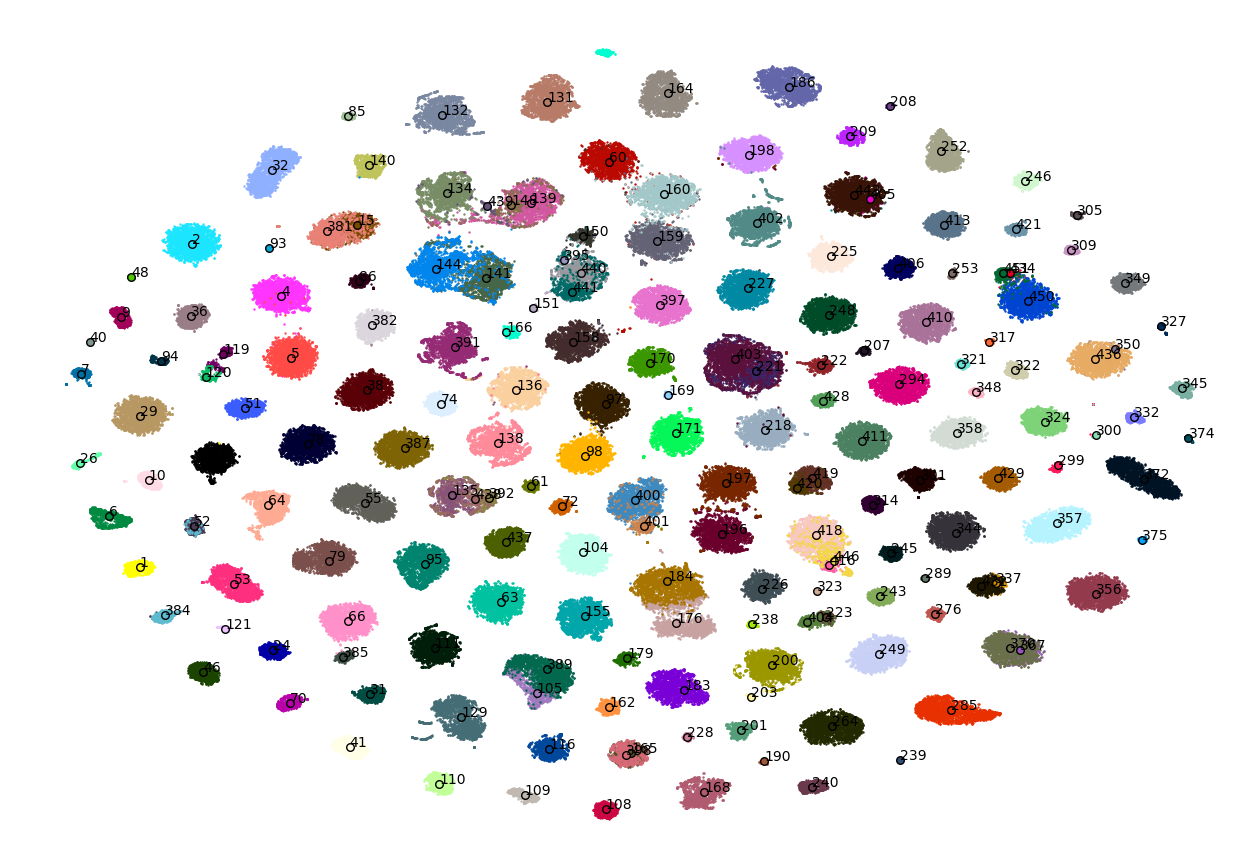

In [61]:
plt.figure(figsize=(16,11))

# spikes
ind = 0
for group in ae_df.groupby('cl'):
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=ind, color=colors[ind], alpha=1); 
    colors_id[int(group[0])] = colors[ind]
    ind += 1

# centroid
ind = 0

for group in ae_df.groupby('cl'):
    # luminance calculation to pick edge color
    h = colors[ind].lstrip("#")
    r,g,b = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    # r, g, b = colors[ind]
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    edgecolor = 'black' # if lum > 90 else 'white'

    plt.scatter(mean_tsne[int(group[0]), 0], mean_tsne[int(group[0]), 1], color=colors[ind], s=30, edgecolor=edgecolor, marker='o')
    plt.annotate(str(int(group[0])), (mean_tsne[int(group[0]), 0], mean_tsne[int(group[0]), 1]), color=edgecolor)
    ind += 1
        
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Kilosort cluster");
plt.axis("off")
# plt.savefig("../figures/paper/bijan_ae_pre_dist.png", transparent=True, dpi=300)

In [32]:
for i in range(len(ae_df)):
    clid = int(ae_df.loc[i, 'cl'])
    ae_df.loc[i, 'cl_merge'] = old2new[clid] if clid in old2new else clid

In [52]:
(ae_df['cl'] == 4).sum()

2000

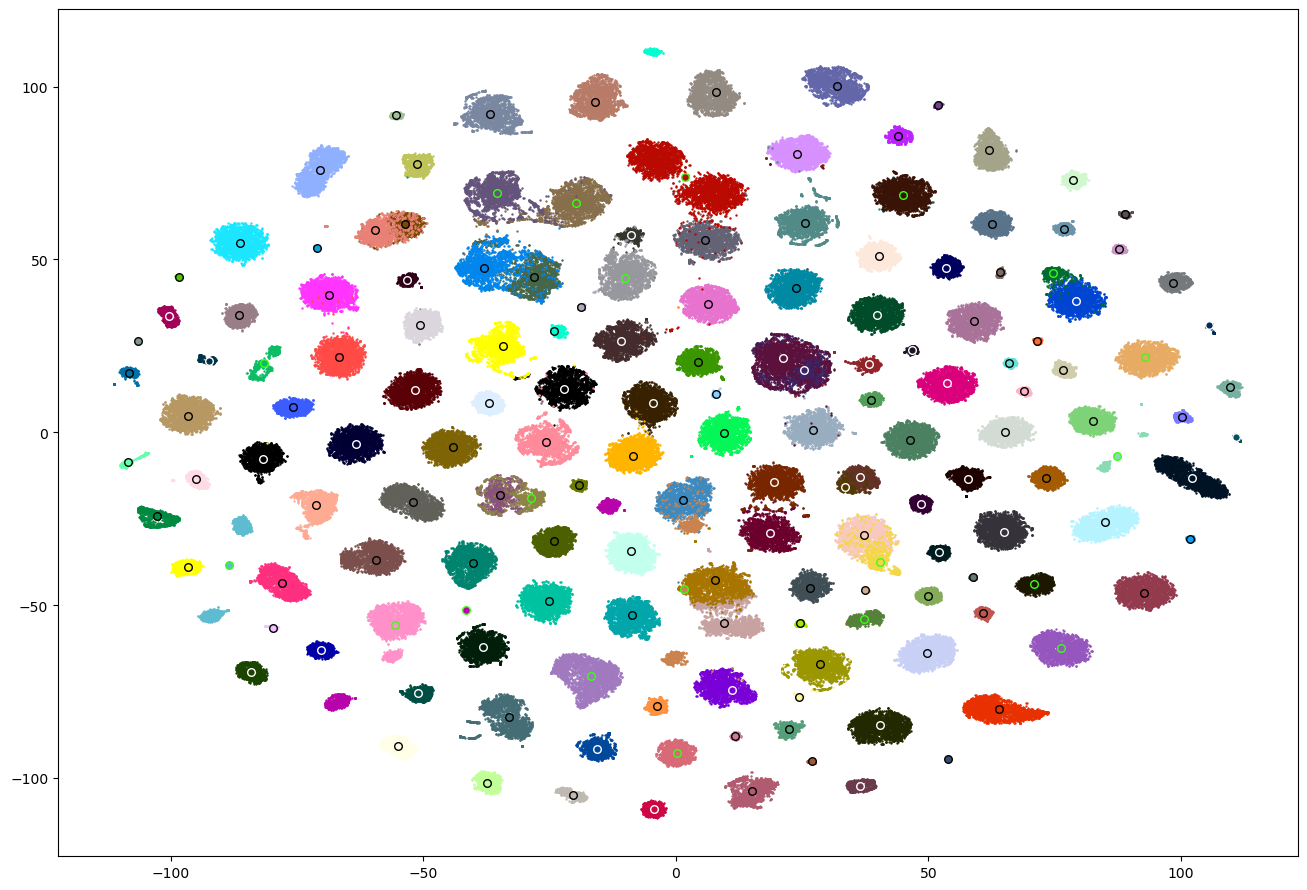

In [182]:
plt.figure(figsize=(16,11))

# spikes
ind = 0
for group in ae_df.groupby('cl_merge'):
    cl = int(group[0])
    color = colors_id[new2old[cl][0]] if cl in new2old else colors_id[cl]
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=cl, color=color, alpha=1); 
    ind += 1

# centroid
ind = 0

for group in ae_df.groupby('cl_merge'):
    # luminance calculation to pick edge color
    cl = int(group[0])
    color = colors_id[new2old[cl][0]] if cl in new2old else colors_id[cl]
    h = color.lstrip("#")
    r,g,b = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    edgecolor = 'black' if lum > 70 else 'white'
    
    # calculate new centroid if needed -- weighted avg of old centroids
    if cl in new2old:
        cl_list = new2old[cl]
        num_tot = 0
        x = 0; y=0;
        for i in range(len(cl_list)):
            num_tot += min(counts[cl_list[i]], 2000)
        for i in range(len(cl_list)):
            num_spk = min(counts[cl_list[i]], 2000)
            x += mean_tsne[cl_list[i], 0] * num_spk/num_tot
            y += mean_tsne[cl_list[i], 1] * num_spk/num_tot
        edgecolor = '#39ff14'
    else:
        x = mean_tsne[int(group[0]), 0]
        y = mean_tsne[int(group[0]), 1]
#     if cl in new2old:
#         cl_list = new2old[cl]
#         x = mean_tsne[cl_list[0], 0]
#         y = mean_tsne[cl_list[0], 1]
        
#     else:
#         x = mean_tsne[int(group[0]), 0]
#         y = mean_tsne[int(group[0]), 1]
        

    plt.scatter(x, y, color=color, s=30, edgecolor=edgecolor, marker='o')
    ind += 1
        
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Kilosort cluster");
# plt.axis("off")
# plt.savefig("../figures/paper/bijan_ae_post_dist.png", transparent=True, dpi=300)

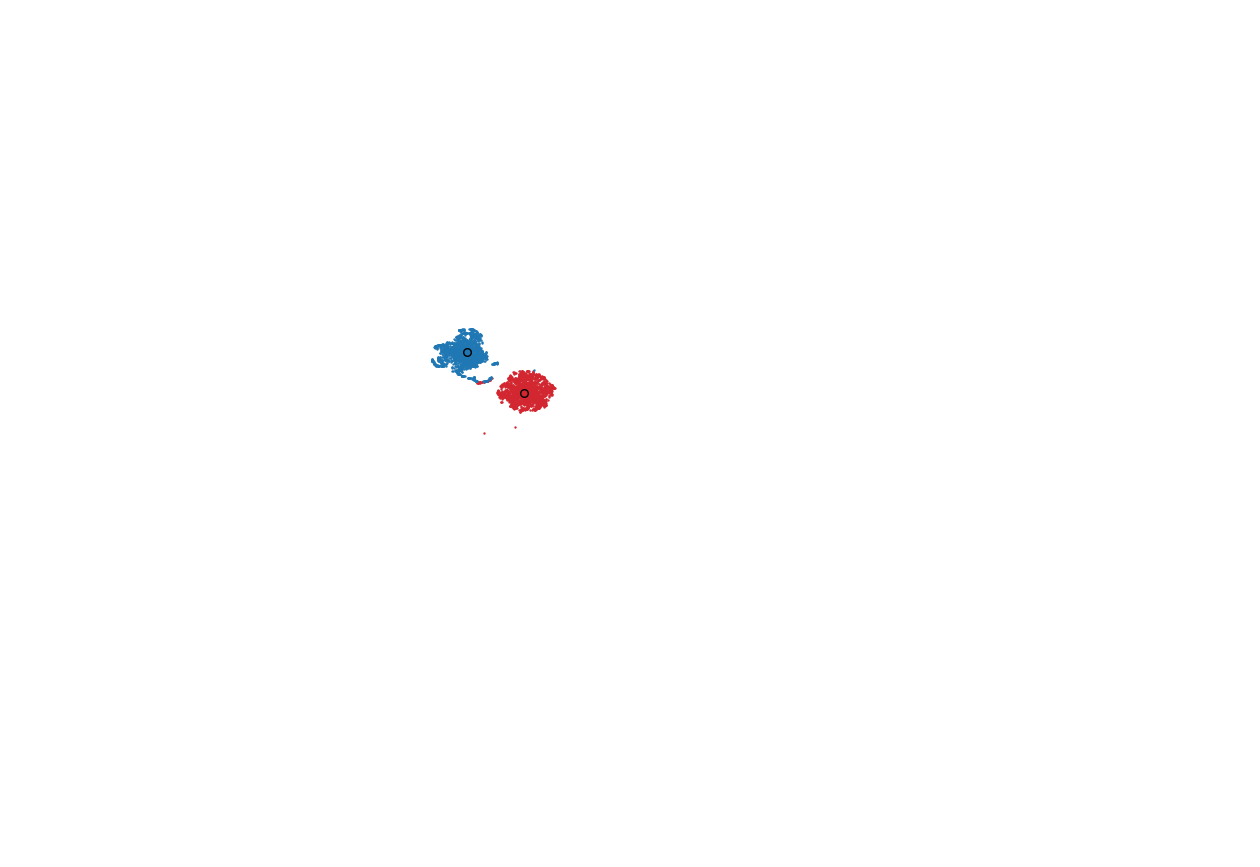

In [187]:
plt.figure(figsize=(16,11))

# spikes
ind = 0
for group in ae_df.groupby('cl'):
    if int(group[0]) not in [136, 391]:
        continue
        
    color = '#1f77b4' if int(group[0]) == 391 else '#d22730'
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=ind, color=color, alpha=1); 
    colors_id[int(group[0])] = colors[ind]
    ind += 1
    
plt.scatter(mean_tsne[136, 0], mean_tsne[136, 1], color = '#d22730', s=30, edgecolor='black', marker= 'o')
plt.scatter(mean_tsne[391, 0], mean_tsne[391, 1], color = '#1f77b4', s=30, edgecolor='black', marker= 'o')
        
# plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Kilosort cluster");
plt.axis("off")
plt.ylim([-130, 130]);plt.xlim([-130, 130]);
plt.savefig("../figures/paper/sim_calc_shape_space.png", transparent=True, dpi=300)

In [171]:
peak_chans[403]

70

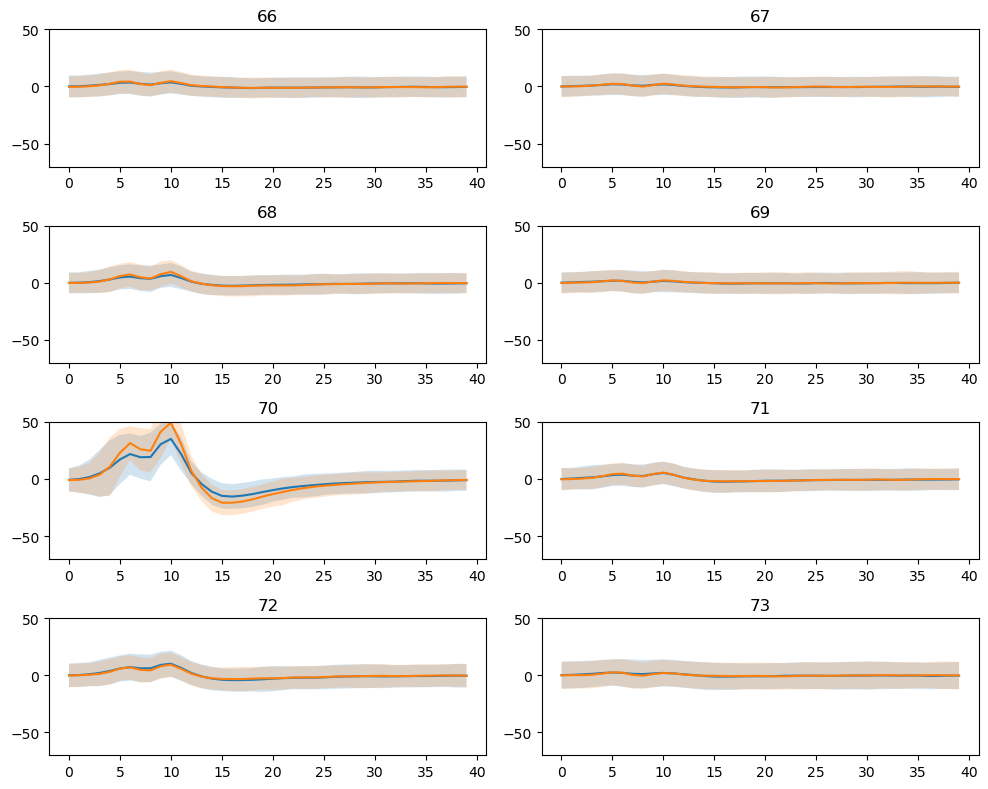

In [177]:
plt.figure(figsize=(10,8))
# idx = 139
for i in range(66, 74):
    plt.subplot(4,2,i+1-66)
    plt.plot(mean_wf[105,i,10:50])
    plt.fill_between(range(40), mean_wf[105,i,10:50]-2*std_wf[105,i,10:50], mean_wf[105,i,10:50]+2*std_wf[105,i,10:50], alpha=0.2)
    
    plt.plot(mean_wf[389,i,10:50])
    plt.fill_between(range(40), mean_wf[389,i,10:50]-2*std_wf[389,i,10:50], mean_wf[389,i,10:50]+2*std_wf[389,i,10:50], alpha=0.2)

    plt.title(i); 
    plt.ylim(-70, 50)
    
plt.tight_layout()
plt.savefig("../figures/paper/bijan_merge_105_389.svg", transparent=True)

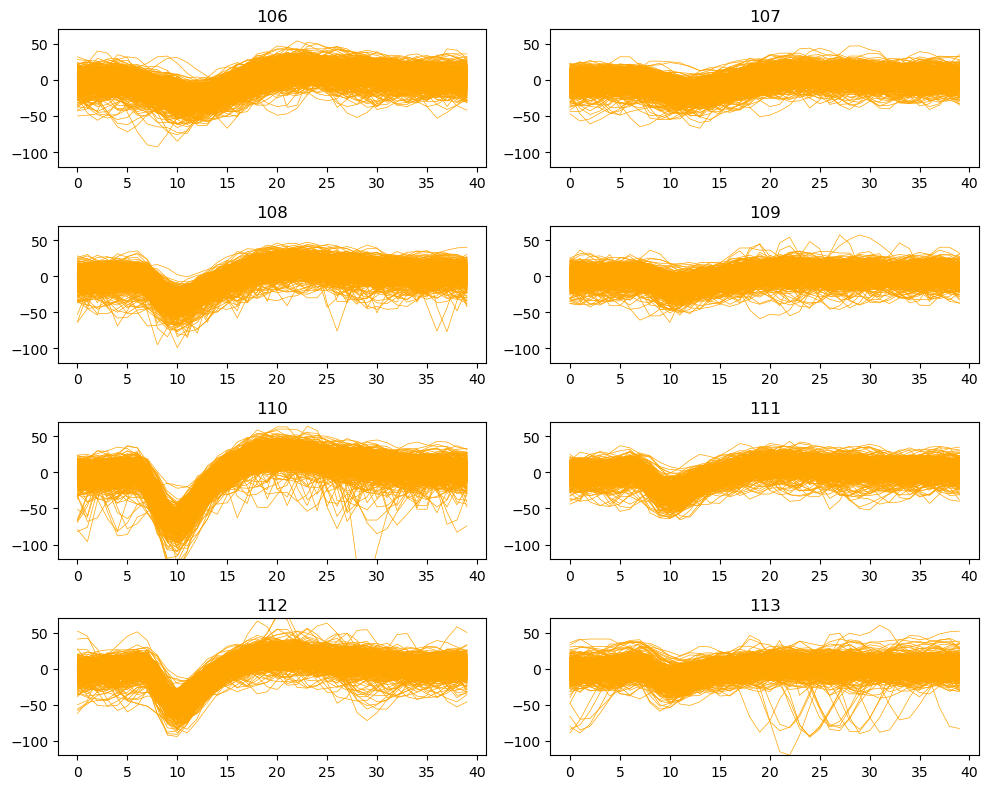

In [152]:
plt.figure(figsize=(10,8))
# idx = 139
for i in range(106, 114):
    plt.subplot(4,2,i+1-106)
    for j in range(spikes[160].shape[0]):
        plt.plot(spikes[160][j,i,10:50], color='orange', linewidth=.5)

    plt.title(i); 
    plt.ylim(-120, 70)
    
plt.tight_layout()
plt.savefig("../figures/paper/bijan_merge_160.svg", transparent=True)

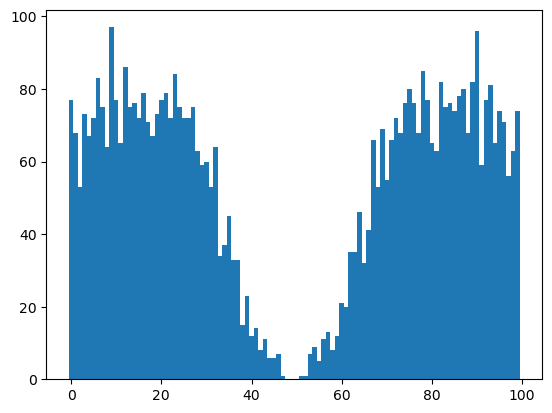

In [154]:
ccg = bd.x_correlogram(times_multi[60]/30000, 
                                       times_multi[160]/30000,
                                       overlap_tol=10/30000)[0]

plt.bar(range(len(ccg)), ccg[::-1], width=1)
plt.savefig("../figures/paper/bijan_ccg_60_160.svg", transparent=True)

In [146]:
ref_pen[15,381]

0.5543203586353891

In [124]:
xcorr_sig[419,420]

0.2008727272727273

In [72]:
mean_lats = torch.Tensor(lat_mean[:, :-1]).to(device)

In [71]:
mean_recon = net.decoder(mean_lats).squeeze().cpu().detach().numpy()

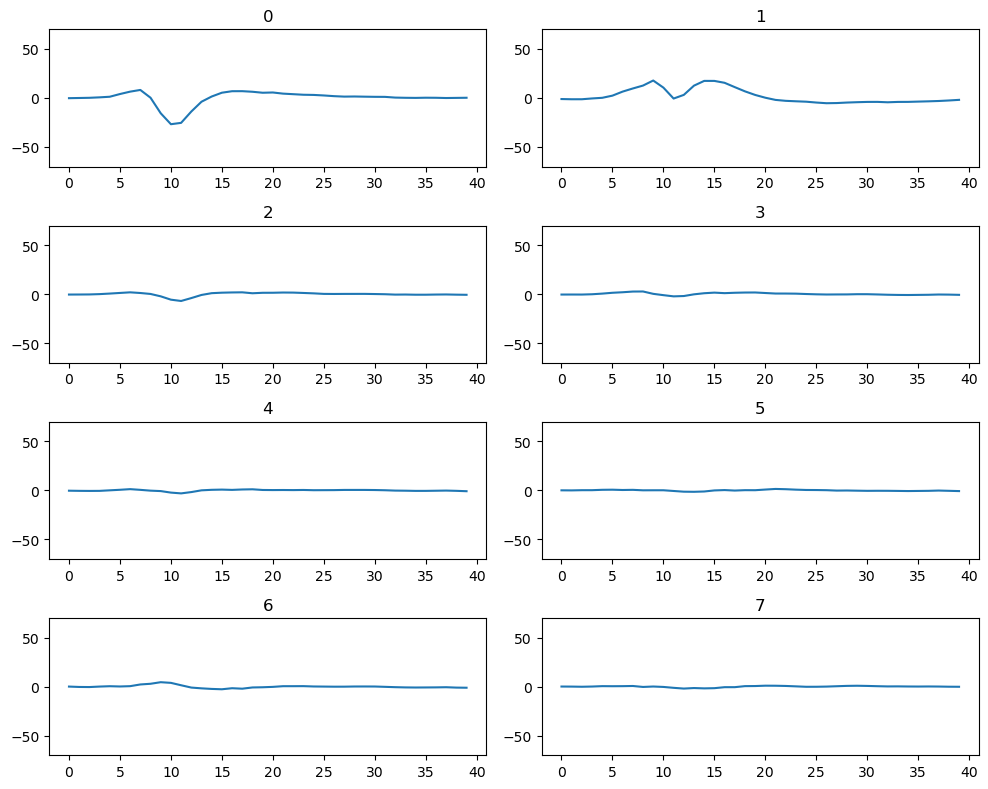

In [596]:
plt.figure(figsize=(10,8))
# idx = 139
ch_cl = chans[240]
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(mean_recon[66, i])
    # plt.plot(mean_recon[121, i])
    # plt.plot(mean_wf[240,ch_cl[i],10:50])
    plt.title(i); plt.ylim(-70, 70)
    
plt.tight_layout()
plt.savefig("../figures/paper/hippo_recon5.svg", transparent=True)

In [469]:
plt.figure(figsize=(10,8))
idx = 66
ch_cl = chans[idx]
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(mean_recon[idx, i])
    plt.plot(mean_wf[idx,ch_cl[i],10:50])
    plt.title(i); plt.ylim(mean_recon[idx,:].min()-10, mean_recon[idx,:].max()+10)
 

In [21]:
os.makedirs(os.path.join(params['KS_folder'], "automerge"), exist_ok=True)
os.makedirs(os.path.join(params['KS_folder'], "automerge", "spikes"), exist_ok=True)
os.makedirs(os.path.join(params['KS_folder'], "automerge", "merges"), exist_ok=True)

# load spike time and cluster estimates
print("Loading files...")

times = np.load(os.path.join(params['KS_folder'], 'spike_times.npy')).flatten()
clusters = np.load(os.path.join(params['KS_folder'], 'spike_clusters.npy')).flatten() 
n_clust = clusters.max() + 1

 # count spikes per cluster, load quality labels
counts = bd.spikes_per_cluster(clusters)
cl_labels = pd.read_csv(os.path.join(params['KS_folder'], 'cluster_group.tsv'), sep="\t")
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))
channel_pos = np.load(os.path.join(params['KS_folder'], "channel_positions.npy"))

# load recording
rawData = np.memmap(params['data_filepath'], dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/params['n_chan']), params['n_chan']))

# filter out low-spike/noise units
cl_good = np.zeros(n_clust, dtype=bool)
unique = np.unique(clusters)
for i in range(n_clust):
     if (i in unique) and (counts[i] > params['min_spikes']) \
        and (cl_labels.loc[cl_labels['cluster_id']==i, 'group'].item() == 'good'):
            cl_good[i] = True

Loading files...


In [22]:
try:
    mean_wf = np.load(os.path.join(params['KS_folder'], 'mean_waveforms.npy'))
    # std_wf = np.load(os.path.join(params['KS_folder'], 'std_waveforms.npy'))
    spikes = None
except OSError:
    print("mean_waveforms.npy doesn't exist, calculating mean waveforms on the fly...")
    mean_wf = np.zeros(
        (n_clust, 
         params['n_chan'],
         params['pre_samples'] + params['post_samples'])
    ) 
    std_wf = np.zeros_like(mean_wf)
    spikes = {}
    for i in range(n_clust):
        if cl_good[i]:
            spikes[i] = bd.extract_spikes(
                data, times_multi, clusters, i,
                n_chan=params['n_chan'],
                pre_samples=params['pre_samples'],
                post_samples=params['post_samples'],
                max_spikes=params['max_spikes']
            )
            mean_wf[i,:,:] = np.nanmean(spikes[i], axis=0)
            # std_wf[i,:,:] = np.nanstd(spikes[i], axis=0)
    np.save(os.path.join(params['KS_folder'], 'mean_waveforms.npy'), mean_wf)
    # np.save(os.path.join(params['KS_folder'], 'mean_waveforms.npy'), std_wf)
peak_chans = np.argmax(np.max(mean_wf, 2) - np.min(mean_wf,2),1)

In [25]:
params['spikes_path'] = spk_fld
params['model_path'] = './models/bijan_vn_15d.pt'
params['sim_type'] = 'ae'

In [26]:
# calculate similarity
if params['sim_type'] == 'ae':
    # calculate nearest channels for each cluster
    chans = {}
    for i in range(mean_wf.shape[0]):
        if i in counts:
            chs, peak = bd.utils.find_best_channels(mean_wf[i], channel_pos, params['ae_chan'])
            dists = bd.utils.get_dists(channel_pos, peak, chs)
            chans[i] = chs[np.argsort(dists)].tolist()

    # extract spikes for ae if necessary
    if params['spikes_path'] == None:
        print("Extracting spike snippets to train autoencoder...")
        spk_fld = os.path.join(params['KS_folder'], "automerge", "spikes")
        ci = {'times': times,
            'times_multi': times_multi,
            'clusters': clusters,
            'counts': counts,
            'labels': cl_labels,
            'mean_wf': mean_wf
        }
        gti = {
            'spk_fld': spk_fld,
            'pre_samples': params['ae_pre'],
            'post_samples': params['ae_post'],
            'num_chan': params['ae_chan'],
            'noise': params['ae_noise'],
            'for_shft': params['ae_shft']
        }
        bd.generate_train_data(data, ci, channel_pos, gti, params)
        print("Spike snippets saved in " + str(spk_fld))
    else:
        spk_fld = params['spikes_path']

    # train model if necessary
    if params['model_path'] == None:
        print("Training autoencoder...")
        net, spk_data = bd.train_ae(spk_fld, counts, do_shft=params['ae_shft'], num_epochs=params['ae_epochs'])
        torch.save(net.state_dict(), os.path.join(params['KS_folder'], "automerge", "ae.pt"))
        print("Autoencoder saved in " + str(os.path.join(params['KS_folder'], "automerge", "ae.pt")))
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        net = bd.autoencoder.CN_AE().to(device)                         
        net.load_state_dict(torch.load(params['model_path']))
        net.eval()
        spk_data = bd.autoencoder.SpikeDataset(os.path.join(spk_fld, 'labels.csv'), spk_fld, ToTensor())

    # calculate ae_similarity
    sim, spk_lat_peak, lat_mean, spk_lab = bd.stages.calc_ae_sim(mean_wf, net, peak_chans, spk_data, chans, cl_good, do_shft=params['ae_shft'])
elif params['sim_type'] == 'mean':
    # calculate mean similarity
    sim, offset, wf_norms, mean_wf, pass_ms = bd.stages.calc_mean_sim(
        data, 
        times_multi, 
        clusters, 
        counts, 
        n_clust,
        labels,
        mean_wf,
        params
    )
    sim[pass_ms == False] = 0
pass_ms = sim > params["sim_thresh"]
print("Found %d candidate cluster pairs" % (pass_ms.sum()/2))

Calculating latent features...
Batch 1567/1567
LOSS: 24.850979179961712
Found 76 candidate cluster pairs


In [27]:
xcorr_sig, xgrams, shfl_xgrams = bd.stages.calc_xcorr_metric(
        times, 
        clusters,
        n_clust, 
        pass_ms, 
        params
)

In [28]:
ref_pen, ref_per = bd.stages.calc_ref_p(times, clusters, n_clust, pass_ms, xcorr_sig,\
                                   params)

In [29]:
final_metric = np.zeros_like(sim)

for c1 in range(n_clust):
    for c2 in range(c1, n_clust):
        met = sim[c1,c2] + \
        params['xcorr_coeff']*xcorr_sig[c1,c2] - \
        params['ref_pen_coeff']*ref_pen[c1,c2]

        final_metric[c1,c2] = max(met, 0)
        final_metric[c2,c1] = max(met, 0)
print("Merging...")

channel_map = np.load(os.path.join(params['KS_folder'], 'channel_map.npy')).flatten()

old2new, new2old = bd.stages.merge_clusters(
    clusters, counts, mean_wf, final_metric, params)

Merging...


In [30]:
new2old

{457: [367, 370],
 458: [105, 389],
 459: [392, 438],
 460: [436, 350],
 461: [432, 337],
 462: [446, 416],
 463: [443, 405],
 464: [398, 165],
 465: [451, 434],
 466: [148, 139],
 467: [384, 52],
 468: [66, 385],
 470: [404, 223],
 471: [300, 299],
 472: [60, 160],
 473: [439, 134],
 474: [120, 119],
 475: [440, 395, 441],
 476: [70, 72],
 477: [401, 179]}

In [77]:
tot = 0
for i in range(clusters.max()+1):
    if (i in counts) and (counts[i] > min_spikes) and (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good'):
        cl_times = times_multi[i].astype("int32")
        
        # cap number of spikes
        if (max_spikes < cl_times.shape[0]):
            np.random.shuffle(cl_times)
            cl_times = cl_times[:max_spikes]
            
        # save spikes to file and add to annotations
        for j in range(cl_times.shape[0]):
            file_names.append("cl%d_spk%d.npy" % (i, j))
            cl_ids.append(i)
            
            spike = data[cl_times[j]-pre_samples:cl_times[j]+post_samples, chans[i]].T
            spike = np.nan_to_num(spike)
            out_name = "./data/bijan_spikes/cl%d_spk%d.npy" % (i, j)
            
            np.save(out_name, spike)

In [78]:
df = pd.DataFrame({'file':file_names, 'cl':cl_ids}, index=None)
df.to_csv("./data/bijan_spikes/labels.csv", header=False, index=False)

In [8]:
class SpikeDataset(Dataset):
    def __init__(self, annotations_file, spk_dir, transform=None, target_transform=None):
        self.spk_labels = pd.read_csv(annotations_file, header=None)
        self.spk_dir = spk_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.spk_labels)

    def __getitem__(self, idx):
        spk_path = os.path.join(self.spk_dir, self.spk_labels.iloc[idx, 0])
        spk = np.load(spk_path).astype('float32')
        label = self.spk_labels.iloc[idx, 1]
        if self.transform:
            spk = self.transform(spk)
        if self.target_transform:
            label = self.target_transform(label)
        return spk, label

In [9]:
spk_data = SpikeDataset("./data/bijan_spikes/labels.csv","./data/bijan_spikes/", ToTensor())

In [10]:
BATCH_SIZE = 128

labels = spk_data.spk_labels.iloc[:, 1].to_numpy()

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(spk_data)),
    labels,
    stratify=labels,
    test_size=0.2,
    random_state=42
)

# generate subset based on indices
train_split = Subset(spk_data, train_indices)
test_split = Subset(spk_data, test_indices)

# sample weighting
sample_weights = [1/counts[int(label)] for label in labels[train_indices]]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_split), replacement=True)


# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

## Net Definition

In [29]:
"""
A Convolutional Variational Autoencoder
"""
class CN_VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=256*1*40, zDim=12):
        super(CN_VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 64, (3,1), padding='same')
        self.encBN1 = nn.BatchNorm2d(64)
        self.encPool1 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv2 = nn.Conv2d(64, 128, (3,1), padding='same')
        self.encBN2 = nn.BatchNorm2d(128)
        self.encPool2 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv3 = nn.Conv2d(128, 256, (3,1), padding='same')
        self.encBN3 = nn.BatchNorm2d(256)
        self.encPool3 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBN1 = nn.BatchNorm2d(256)
        
        self.decUpSamp1 = nn.Upsample((2,40))
        self.decConv1 = nn.ConvTranspose2d(256, 128, (3,1), padding=(1,0))
        self.decBN2 = nn.BatchNorm2d(128)
        
        self.decUpSamp2 = nn.Upsample((4,40))
        self.decConv2 = nn.ConvTranspose2d(128, 64, (3,1), padding=(1,0))
        self.decBN3 = nn.BatchNorm2d(64)
        
        self.decUpSamp3 = nn.Upsample((8,40))
        self.decConv3 = nn.ConvTranspose2d(64, imgChannels, (3,1), padding=(1,0))


    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encBN1(self.encConv1(x)))
        x, self.encInd1 = self.encPool1(x)
        
        x = F.relu(self.encBN2(self.encConv2(x)))
        x, self.encInd2 = self.encPool2(x)
        
        x = F.relu(self.encBN3(self.encConv3(x)))
        x, self.encInd3 = self.encPool3(x)
        
        x = x.view(-1, 256*1*40)
        
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decFC1(z)
        x = x.view(-1, 256, 1, 40)
        x = F.relu(self.decBN1(x))
        x = self.decUpSamp1(x)
 
        x = F.relu(self.decBN2(self.decConv1(x)))
        x = self.decUpSamp2(x)
        
        x = F.relu(self.decBN3(self.decConv2(x)))
        x = self.decUpSamp3(x)
        x = self.decConv3(x)
        
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [16]:
class CN_AE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=256*1*5, zDim=15):
        super(CN_AE, self).__init__()
        
        self.encConv1 = nn.Conv2d(imgChannels, 64, (3,3), padding='same')
        self.encBN1 = nn.BatchNorm2d(64)
        self.encPool1 = nn.MaxPool2d((2,2), return_indices=True)
        
        self.encConv2 = nn.Conv2d(64, 128, (3,3), padding='same')
        self.encBN2 = nn.BatchNorm2d(128)
        self.encPool2 = nn.MaxPool2d((2,2), return_indices=True)
        
        self.encConv3 = nn.Conv2d(128, 256, (3,3), padding='same')
        self.encBN3 = nn.BatchNorm2d(256)
        self.encPool3 = nn.MaxPool2d((2,2), return_indices=True)
        
        self.encFC1 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBN1 = nn.BatchNorm2d(256)
        
        self.decUpSamp1 = nn.Upsample((2,10))
        self.decConv1 = nn.ConvTranspose2d(256, 128, (3,3), padding=(1,1))
        self.decBN2 = nn.BatchNorm2d(128)
        
        self.decUpSamp2 = nn.Upsample((4,20))
        self.decConv2 = nn.ConvTranspose2d(128, 64, (3,3), padding=(1,1))
        self.decBN3 = nn.BatchNorm2d(64)
        
        self.decUpSamp3 = nn.Upsample((8,40))
        self.decConv3 = nn.ConvTranspose2d(64, imgChannels, (3,3), padding=(1,1))

    def encoder(self, x):
        # Input is fed into 2 convolutional layers sequentially
     
        x = F.relu(self.encConv1(x))
        x, self.encInd1 = self.encPool1(x)
        
        x = F.relu(self.encConv2(x))
        x, self.encInd2 = self.encPool2(x)
        
        x = F.relu(self.encConv3(x))
        x, self.encInd3 = self.encPool3(x)
        
        x = x.view(-1, 256*1*5)
        
        x = self.encFC1(x)
        
        return x

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decFC1(z)
        x = x.view(-1, 256, 1, 5)
        x = F.relu(x)
        
        x = self.decUpSamp1(x)
        x = F.relu(self.decConv1(x))
        
        x = self.decUpSamp2(x)
        x = F.relu(self.decConv2(x))
        
        x = self.decUpSamp3(x)
        x = self.decConv3(x)
        
        return x

    def forward(self, x):

        # The entire pipeline of the AE: encoder -> decoder
        z = self.encoder(x)
        out = self.decoder(z)
        
        return out

In [21]:
"""
A Convolutional Skip Autoencoder
"""
class CNS_AE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=256*1*40, zDim=15):
        super(CNS_AE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 64, (3,1), padding='same')
        self.encBN1 = nn.BatchNorm2d(64)
        self.encPool1 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv2 = nn.Conv2d(64, 128, (3,1), padding='same')
        self.encBN2 = nn.BatchNorm2d(128)
        self.encPool2 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv3 = nn.Conv2d(128, 256, (3,1), padding='same')
        self.encBN3 = nn.BatchNorm2d(256)
        self.encPool3 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encFC1 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBN1 = nn.BatchNorm2d(256)
        
        self.decUpSamp1 = nn.Upsample((2,40))
        self.decConv1 = nn.ConvTranspose2d(512, 128, (3,1), padding=(1,0))
        self.decBN2 = nn.BatchNorm2d(128)
        
        self.decUpSamp2 = nn.Upsample((4,40))
        self.decConv2 = nn.ConvTranspose2d(256, 64, (3,1), padding=(1,0))
        self.decBN3 = nn.BatchNorm2d(64)
        
        self.decUpSamp3 = nn.Upsample((8,40))
        self.decConv3 = nn.ConvTranspose2d(128, imgChannels, (3,1), padding=(1,0))
        
        # Initializing skip connection layers
        


    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        self.skip1 = F.relu(self.encBN1(self.encConv1(x)))
        x, self.encInd1 = self.encPool1(self.skip1)
        
        self.skip2 = F.relu(self.encBN2(self.encConv2(x)))
        x, self.encInd2 = self.encPool2(self.skip2)
        
        self.skip3 = F.relu(self.encBN3(self.encConv3(x)))
        x, self.encInd3 = self.encPool3(self.skip3)
        
        x = x.view(-1, 256*1*40)
        
        x = self.encFC1(x)
        
        return x

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decFC1(z)
        x = x.view(-1, 256, 1, 40)
        x = F.relu(self.decBN1(x))
        x = torch.cat((self.decUpSamp1(x), self.skip3), dim=1)
 
        x = F.relu(self.decBN2(self.decConv1(x)))
        x = torch.cat((self.decUpSamp2(x), self.skip2), dim=1)
        
        x = F.relu(self.decBN3(self.decConv2(x)))
        x = torch.cat((self.decUpSamp3(x), self.skip1), dim=1)
        x = self.decConv3(x)
        
        return x

    def forward(self, x):

        # The entire pipeline of the AE: encoder -> decoder
        z = self.encoder(x)
        out = self.decoder(z)
        
        return out

In [8]:
"""
A Linear Convolutional Autoencoder
"""
class Lin_AE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=256*1*40, zDim=15):
        super(Lin_AE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 64, (3,1), padding='same')
        self.encLin1 = nn.Linear(64*8*40, 64*4*40)
        
        self.encConv2 = nn.Conv2d(64, 128, (3,1), padding='same')
        self.encLin2 = nn.Linear(128*4*40, 128*2*40)
        
        self.encConv3 = nn.Conv2d(128, 256, (3,1), padding='same')
        self.encLin3 = nn.Linear(256*2*40, 256*1*40)
        
        self.encFC1 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        
        self.decLin1 = nn.Linear(256*1*40, 256*2*40)
        self.decConv1 = nn.ConvTranspose2d(256, 128, (3,1), padding=(1,0))
        
        self.decLin2 = nn.Linear(128*2*40, 128*4*40)
        self.decConv2 = nn.ConvTranspose2d(128, 64, (3,1), padding=(1,0))
        
        self.decLin3 = nn.Linear(64*4*40, 64*8*40)
        self.decConv3 = nn.ConvTranspose2d(64, imgChannels, (3,1), padding=(1,0))

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.encConv1(x)
        x = x.view(-1, 64*8*40)
        x = self.encLin1(x)
        x = x.view(-1, 64, 4, 40)
        
        x = self.encConv2(x)
        x = x.view(-1, 128*4*40)
        x = self.encLin2(x)
        x = x.view(-1, 128, 2, 40)
        
        x = self.encConv3(x)
        x = x.view(-1, 256*2*40)
        x = self.encLin3(x)

        x = self.encFC1(x)
        
        return x

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decFC1(z)

        x = self.decLin1(x)
        x = x.view(-1, 256, 2, 40)
        x = self.decConv1(x)
        x = x.view(-1, 128*2*40)
        
        x = self.decLin2(x)
        x = x.view(-1, 128, 4, 40)
        x = self.decConv2(x)
        x = x.view(-1, 64*4*40)
        
        x = self.decLin3(x)
        x = x.view(-1, 64, 8, 40)
        x = self.decConv3(x)
        
        return x

    def forward(self, x):

        # The entire pipeline of the AE: encoder -> decoder
        z = self.encoder(x)
        out = self.decoder(z)
        
        return out

## Train

In [17]:
torch.cuda.empty_cache()

In [18]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 7
test_loss = np.zeros(10)

"""
Initialize the network and the Adam optimizer
"""
net = CN_AE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)
loss_fn = nn.MSELoss()

In [21]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    print('EPOCH %d' % (epoch))
    running_loss = 0
    last_loss = 0
    net.train()
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out = net(imgs)
        loss = loss_fn(out, imgs)
        
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_sched.step()
        
        # Gather data and report
        running_loss += loss
        if idx % 500 == 499:
            last_loss = running_loss/500
            print(" Batch %d | loss: %.4f" % (idx, last_loss))
            running_loss = 0
        
    print()
    # test error
    running_tloss = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print("\r" + str(i), end="")
            imgs, _ = data
            imgs = imgs.to(device)
            
            out = net(imgs)
            tloss = loss_fn(out, imgs)
            running_tloss += tloss
        
    avg_vloss = running_tloss/(i+1)
    test_loss[epoch] = avg_vloss
    
    print("\nLOSS | train: %.4f | test %.4f" % (last_loss, avg_vloss))

EPOCH 0
499 Batch 499 | loss: 30.2906
999 Batch 999 | loss: 23.5963
1253
313
LOSS | train: 23.5963 | test 24.7902
EPOCH 1
499 Batch 499 | loss: 22.2093
999 Batch 999 | loss: 21.6277
1253
313
LOSS | train: 21.6277 | test 23.5609
EPOCH 2
499 Batch 499 | loss: 21.1786
999 Batch 999 | loss: 20.9802
1253
313
LOSS | train: 20.9802 | test 23.1859
EPOCH 3
499 Batch 499 | loss: 20.6678
999 Batch 999 | loss: 20.6026
1253
313
LOSS | train: 20.6026 | test 22.9245
EPOCH 4
499 Batch 499 | loss: 20.4550
999 Batch 999 | loss: 20.4253
1253
313
LOSS | train: 20.4253 | test 22.7246
EPOCH 5
499 Batch 499 | loss: 20.2671
999 Batch 999 | loss: 20.1216
1253
313
LOSS | train: 20.1216 | test 22.4713
EPOCH 6
499 Batch 499 | loss: 20.1081
999 Batch 999 | loss: 19.9500
1253
313
LOSS | train: 19.9500 | test 22.4648


In [ ]:
torch.save(net.state_dict(), './models/bijan_vn_15d_balanced.pt')

In [46]:
params = {}

params["calc_means"] = False
params["fs"] = 30000
params["n_chan"] = 385
params["pre_samples"] = 20
params["post_samples"] = 62
params["max_spikes"] = 2000

params["skip_cross_sim"] = False

params["jitter"] = False
params["jitter_amt"] = 4
params["sim_thresh"] = 0.4
params["sp_num_thresh"] = 100

params["n_iter"] = 50
params["shuffle_bin_width"] = 0.1
params["window_size"] = 0.01
params["xcorr_bin_width"] = 0.0005
params["overlap_tol"] = 10/30000
params["max_window"] = 0.01
params["min_xcorr_rate"] = 800

params["xcorr_ref_p"] = 0.0005
params["ref_pers"] = [0.002]
params["max_viol"] = 0.01

params["xcorr_coeff"] =  0.5
params["ref_pen_coeff"] = 1
params["final_thresh"] = 0.7
params["max_dist"] = 10

In [18]:
nonz = 0
labels = pd.read_csv(os.path.join(ks_dir, "cluster_group.tsv"), sep="\t", index_col=False)

for i in range(mean_wf.shape[0]):
    if (i in counts): #and (counts[i] > params["sp_num_thresh"]) and (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good'):
        nonz +=1

In [19]:
orig_id = {}
mean_wf_near = np.zeros((nonz, 8, 40))
ind=0

for i in range(mean_wf.shape[0]):
    if (i in counts): #and (counts[i] > params["sp_num_thresh"]) and (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good'):
        orig_id[ind] = i
        mean_wf_near[ind] = mean_wf[i,chans[i],10:50] 
        
        ind += 1

In [20]:
mean_wf_near = torch.Tensor(mean_wf_near).to(device).unsqueeze(1)

In [22]:
mean_wf_lat = net.encoder(mean_wf_near).squeeze().cpu().detach().numpy()

In [23]:
ae_dist = dist.squareform(dist.pdist(mean_wf_lat, 'euclidean'))

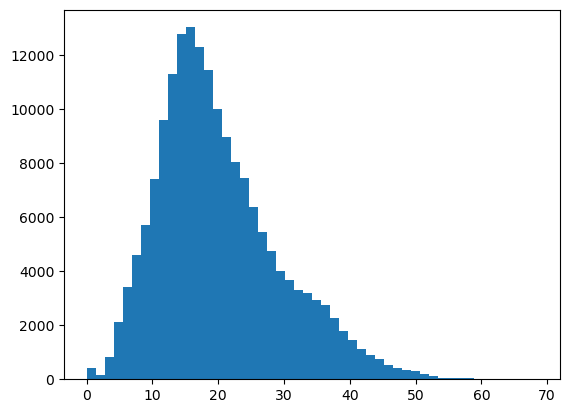

In [31]:
plt.hist(ae_dist.flatten(), bins=50);

In [32]:
ae_dist = dist.squareform(dist.pdist(mean_wf_lat, 'euclidean'))
ae_sim = np.exp(-1*ae_dist)

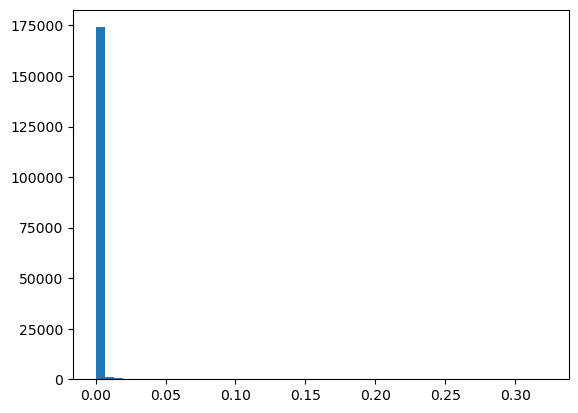

In [42]:
plt.hist(ae_sim.flatten(), bins=50);

In [39]:
for i in range(ae_dist.shape[0]):
    ae_sim[i,i] = 0

(array([34., 18., 16., 18.,  2., 18.,  4., 14., 12.,  8.,  4.,  4.,  6.,
         4.,  2.,  0.,  4.,  6.,  2.,  0.,  0.,  0.,  0.,  4.,  4.,  2.,
         0.,  2.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([0.01015555, 0.01322052, 0.0162855 , 0.01935048, 0.02241546,
        0.02548044, 0.02854542, 0.0316104 , 0.03467537, 0.03774035,
        0.04080533, 0.04387031, 0.04693529, 0.05000027, 0.05306524,
        0.05613022, 0.0591952 , 0.06226018, 0.06532516, 0.06839014,
        0.07145511, 0.07452009, 0.07758507, 0.08065005, 0.08371503,
        0.08678001, 0.08984499, 0.09290996, 0.09597494, 0.09903992,
        0.1021049 , 0.10516988, 0.10823486, 0.11129983, 0.11436481,
        0.11742979, 0.12049477, 0.12355975, 0.12662473, 0.1296897 ,
        0.13275468, 0.13581966, 0.13888464, 0.14194962, 0.1450146 ,
        0.14807958, 0.15114455, 0.15420953, 0.15727451, 0.16033949,
        0.16340447]),
 <BarContainer

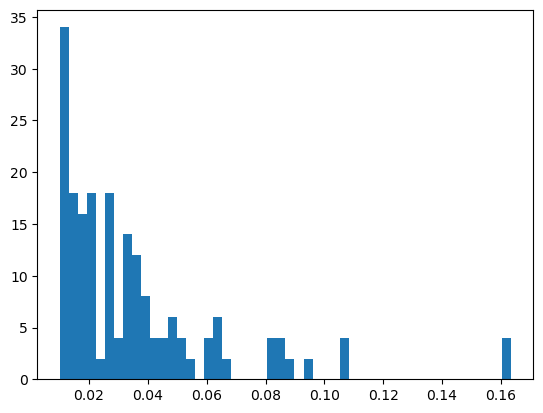

In [67]:
plt.hist(ae_sim.flatten()[ae_sim.flatten() > 0.01], bins=50)

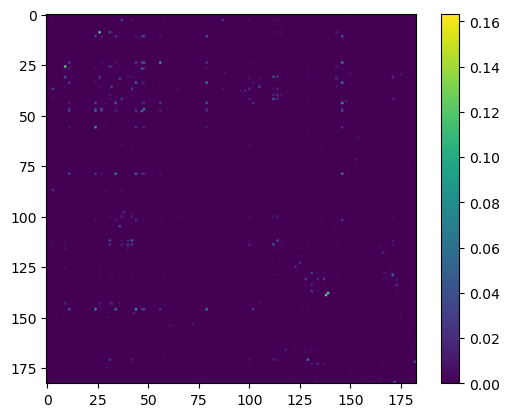

In [55]:
plt.imshow(ae_sim); plt.colorbar();

In [56]:
np.array(np.unravel_index(np.argsort(ae_sim.flatten()), ae_sim.shape)).T[-20:]

array([[ 48,  47],
       [ 47,  48],
       [ 34, 146],
       [146,  34],
       [171, 129],
       [129, 171],
       [ 34,  79],
       [ 79,  34],
       [ 79, 146],
       [146,  79],
       [146,  24],
       [ 24, 146],
       [146,  44],
       [ 44, 146],
       [ 56,  24],
       [ 24,  56],
       [139, 138],
       [138, 139],
       [ 26,   9],
       [  9,  26]], dtype=int64)

In [57]:
ae_sim[9,26]

0.16340446760509583

In [58]:
orig_id[9], orig_id[26]

(15, 61)

In [59]:
orig_id[138], orig_id[139]

(367, 370)

In [61]:
orig_id[44], orig_id[146]

(108, 385)

In [66]:
mean_sim[367,370]

0.848496491982403

In [56]:
imgs, _ = next(iter(test_loader))
imgs = imgs.to(device)
out = net(imgs).squeeze().cpu().detach().numpy()
imgs = imgs.squeeze().cpu().detach().numpy()

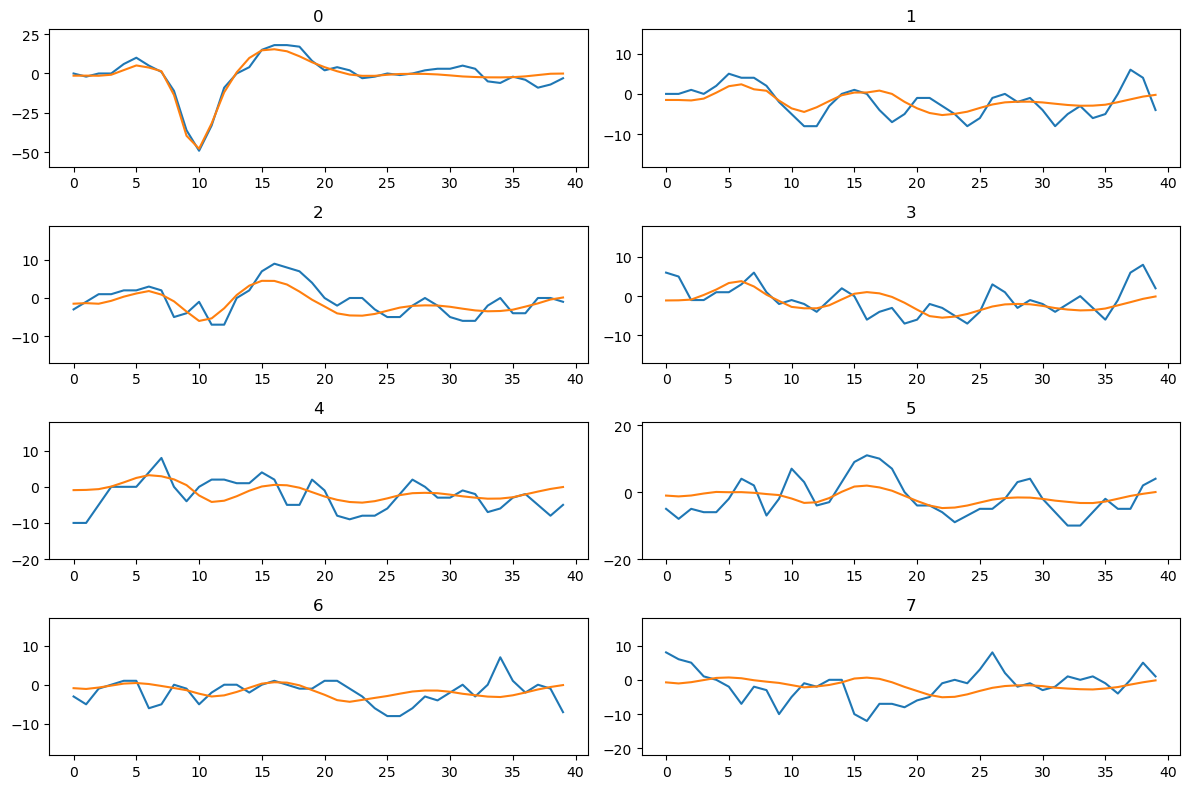

In [92]:
idx = 3
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(imgs[idx, i])
    plt.plot(out[idx, i])
    plt.title(i); plt.ylim(imgs[idx, i].min()-10, imgs[idx, i].max()+10)
    
plt.tight_layout()

## TSNE Comparison of Autoencoder and PCA

In [11]:
train_lat = np.zeros((len(train_indices), 15))
train_lab = np.zeros(len(train_indices))

In [25]:
with torch.no_grad():
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, lab = data
        imgs = imgs.to(device)
        
        out = net.encoder(imgs)
        train_lat[128*idx:(idx+1)*128,:] = out.cpu().detach().numpy()
        train_lab[128*idx:(idx+1)*128] = lab.cpu().detach().numpy()

1253

In [153]:
train_lat_dist = np.hstack((train_lat, 0.1*np.expand_dims(np.array(ae_df['peak']), 1)))

In [123]:
train_lat_dist.shape

(160446, 16)

In [158]:
train_lat.std()

2.57186600669586

In [157]:
train_lat_dist.std(axis=0)

array([1.76047579, 2.12138008, 2.53068353, 3.43327545, 1.84478925,
       2.02811871, 2.38700604, 2.75503985, 1.94537052, 2.16383075,
       1.52285399, 2.71976888, 2.04063085, 2.69594049, 2.48641842,
       9.70153545])

In [154]:
tsne = TSNE(n_components = 2)
lat_tsne = tsne.fit_transform(train_lat_dist)
ae_df = pd.DataFrame({'tsne_1': lat_tsne[:,0], 'tsne_2': lat_tsne[:,1], 'cl': train_lab})

In [139]:
colors = ["#000000","#FFFF00","#1CE6FF","#FF34FF","#FF4A46","#008941","#006FA6","#A30059","#FFDBE5","#7A4900","#0000A6","#63FFAC","#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693","#FEFFE6","#1B4400","#4FC601","#3B5DFF","#4A3B53","#FF2F80","#61615A","#BA0900","#6B7900","#00C2A0","#FFAA92","#FF90C9","#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299","#300018","#0AA6D8","#013349","#00846F","#372101","#FFB500","#C2FFED","#A079BF","#CC0744","#C0B9B2","#C2FF99","#001E09","#00489C","#6F0062","#0CBD66","#EEC3FF","#456D75","#B77B68","#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A","#D157A0","#BEC459","#456648","#0086ED","#886F4C","#34362D","#B4A8BD","#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F","#938A81","#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757","#C8A1A1","#1E6E00","#7900D7","#A77500","#6367A9","#A05837","#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F","#201625","#72418F","#BC23FF","#99ADC0","#3A2465","#922329","#5B4534","#FDE8DC","#404E55","#0089A3","#CB7E98","#A4E804","#324E72","#6A3A4C","#83AB58","#001C1E","#D1F7CE","#004B28","#C8D0F6","#A3A489","#806C66","#222800","#BF5650","#E83000","#66796D","#DA007C","#FF1A59","#8ADBB4","#1E0200","#5B4E51","#C895C5","#320033","#FF6832","#66E1D3","#CFCDAC","#D0AC94","#7ED379","#012C58","#7A7BFF","#D68E01","#353339","#78AFA1","#FEB2C6","#75797C","#837393","#943A4D","#B5F4FF","#D2DCD5","#9556BD","#6A714A","#001325","#02525F","#0AA3F7","#E98176","#DBD5DD","#5EBCD1","#3D4F44","#7E6405","#02684E","#962B75","#8D8546","#9695C5","#E773CE","#D86A78","#3E89BE","#CA834E","#518A87","#5B113C","#55813B","#E704C4","#00005F","#A97399","#4B8160","#59738A","#FF5DA7","#F7C9BF","#643127","#513A01","#6B94AA","#51A058","#A45B02","#1D1702","#E20027","#E7AB63","#4C6001","#9C6966","#64547B","#97979E","#006A66","#391406","#F4D749","#0045D2","#006C31","#DDB6D0","#7C6571","#9FB2A4","#00D891","#15A08A","#BC65E9","#C6DC99","#203B3C","#671190","#6B3A64","#F5E1FF","#FFA0F2","#CCAA35","#374527","#8BB400","#797868","#C6005A","#3B000A","#C86240","#29607C","#402334","#7D5A44","#CCB87C","#B88183","#AA5199","#B5D6C3","#A38469","#9F94F0","#A74571","#B894A6","#71BB8C","#00B433","#789EC9","#6D80BA","#953F00","#5EFF03","#E4FFFC","#1BE177","#BCB1E5","#76912F","#003109","#0060CD","#D20096","#895563","#29201D","#5B3213","#A76F42","#89412E","#1A3A2A","#494B5A","#A88C85","#F4ABAA","#A3F3AB","#00C6C8","#EA8B66","#958A9F","#BDC9D2","#9FA064","#BE4700","#658188","#83A485","#453C23","#47675D","#3A3F00","#061203","#DFFB71","#868E7E","#98D058","#6C8F7D","#D7BFC2","#3C3E6E","#D83D66","#2F5D9B","#6C5E46","#D25B88","#5B656C","#00B57F","#545C46","#866097","#365D25","#252F99","#00CCFF","#674E60","#FC009C","#92896B"]

In [152]:
for i in range(ae_df.shape[0]):
    ae_df.loc[i, 'peak'] = chans[ae_df.loc[i, 'cl']][0]

Text(0.5, 1.0, 'Autoencoder Latent TSNE colored by Kilosort cluster')

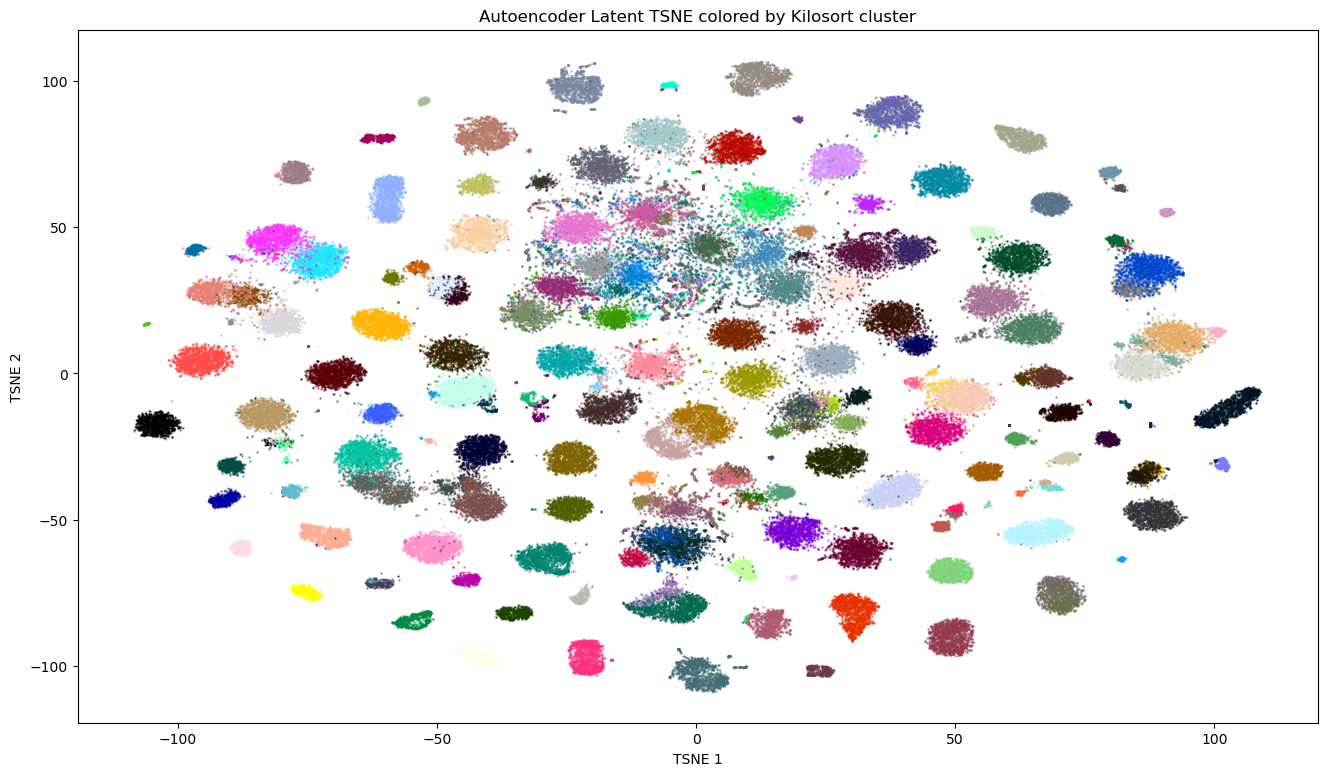

In [156]:
plt.figure(figsize=(16,9))
ind = 0
for group in ae_df.groupby('cl'):
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=ind, color=colors[ind], alpha=0.5); 
    ind += 1
    
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Kilosort cluster")

C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_10304\129618478.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,9))


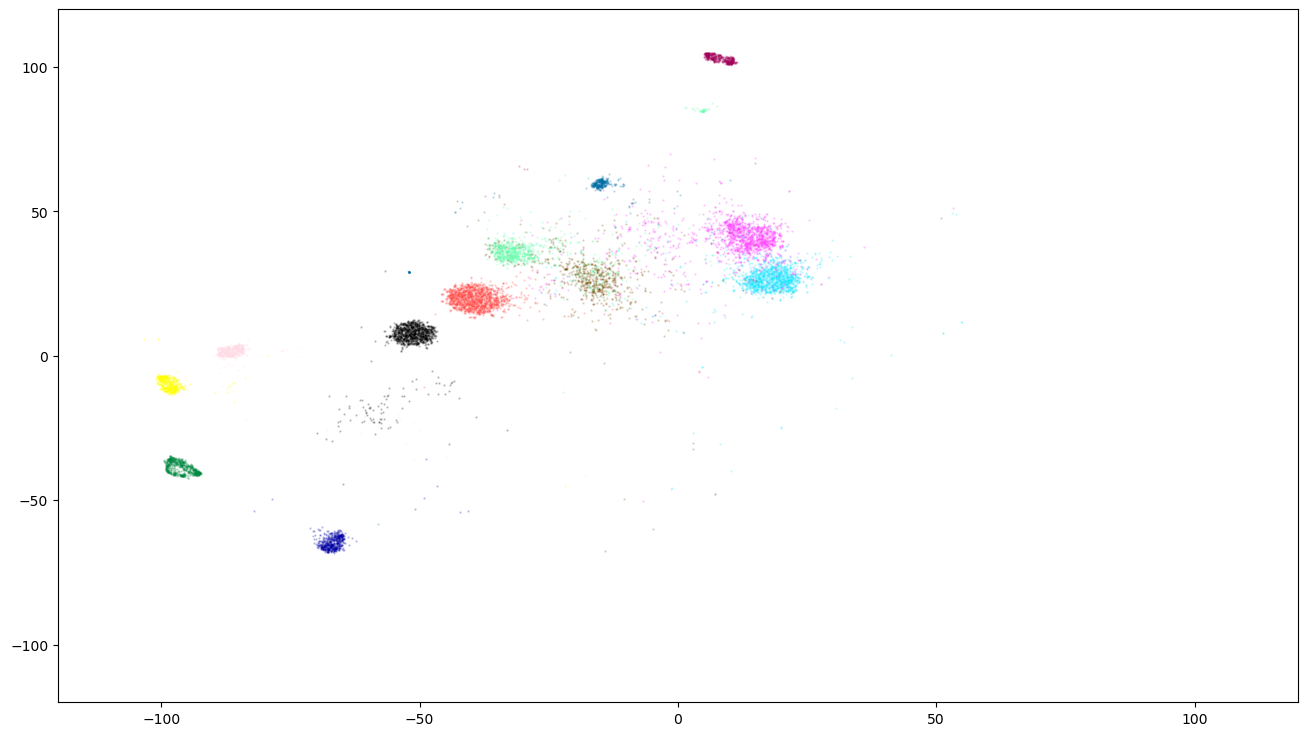

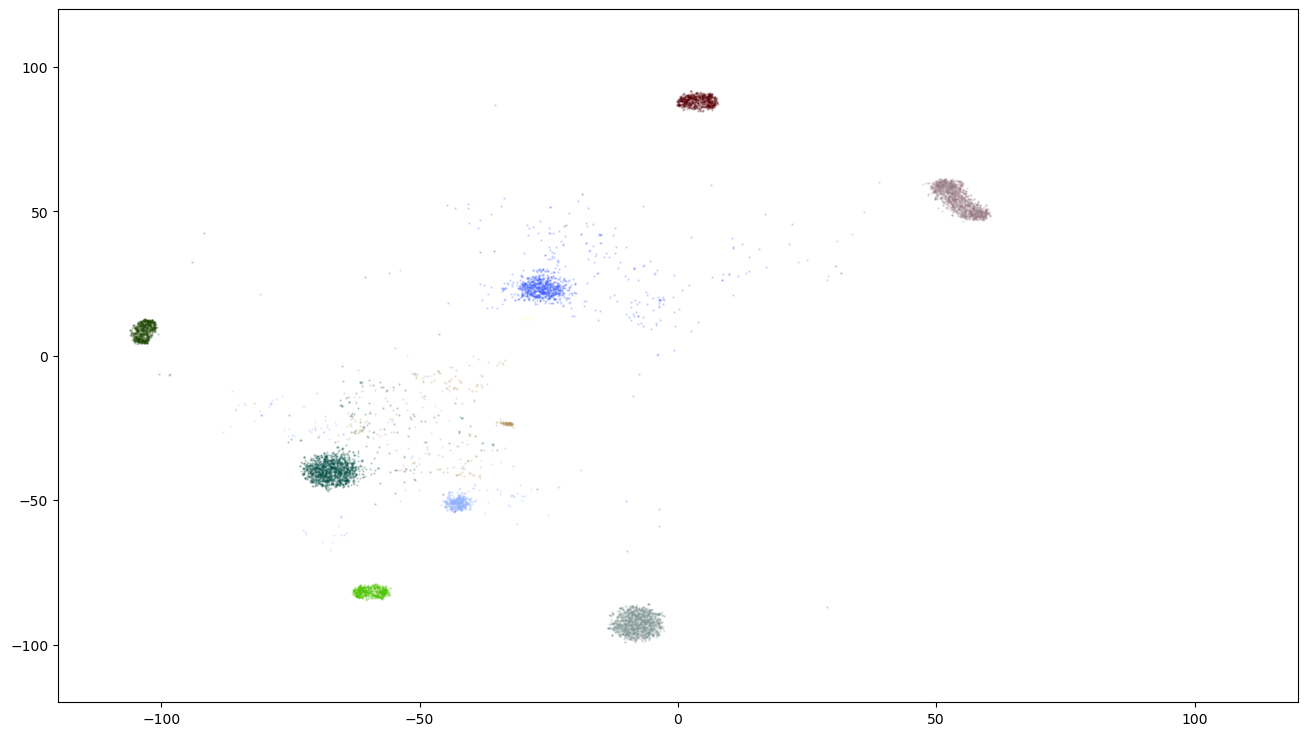

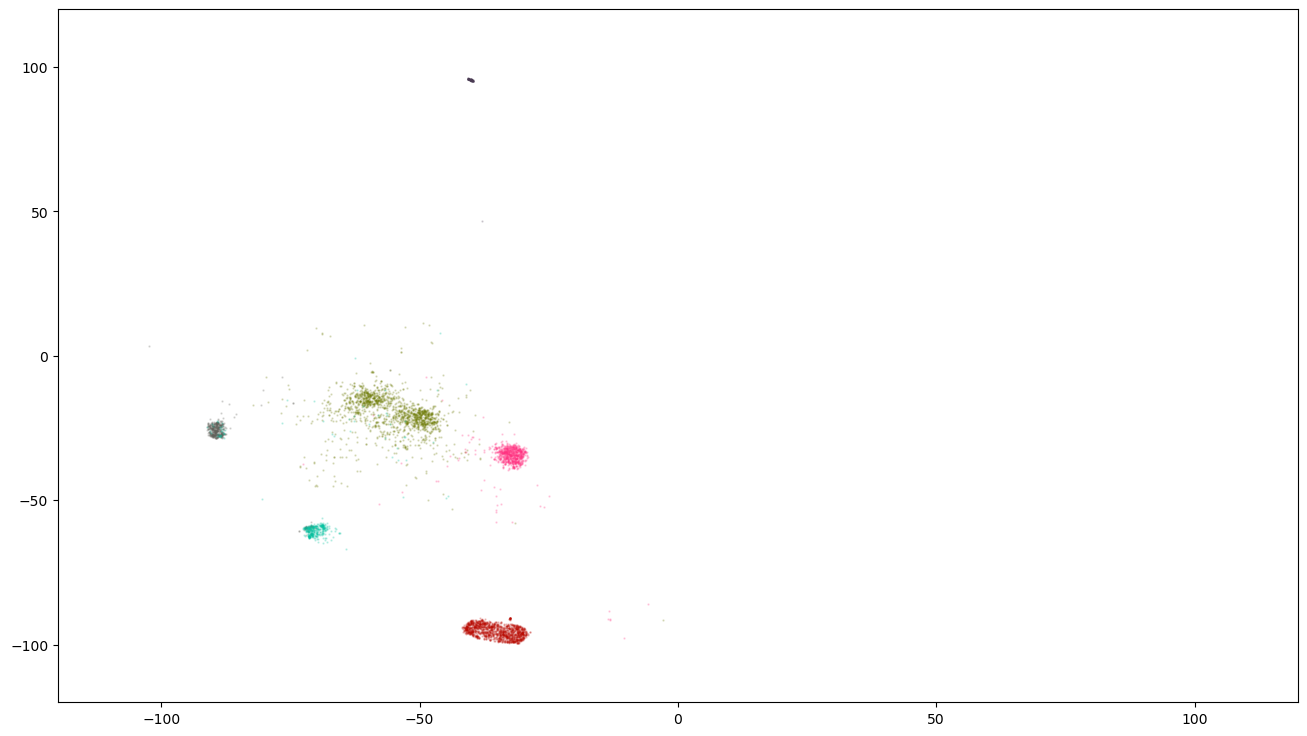

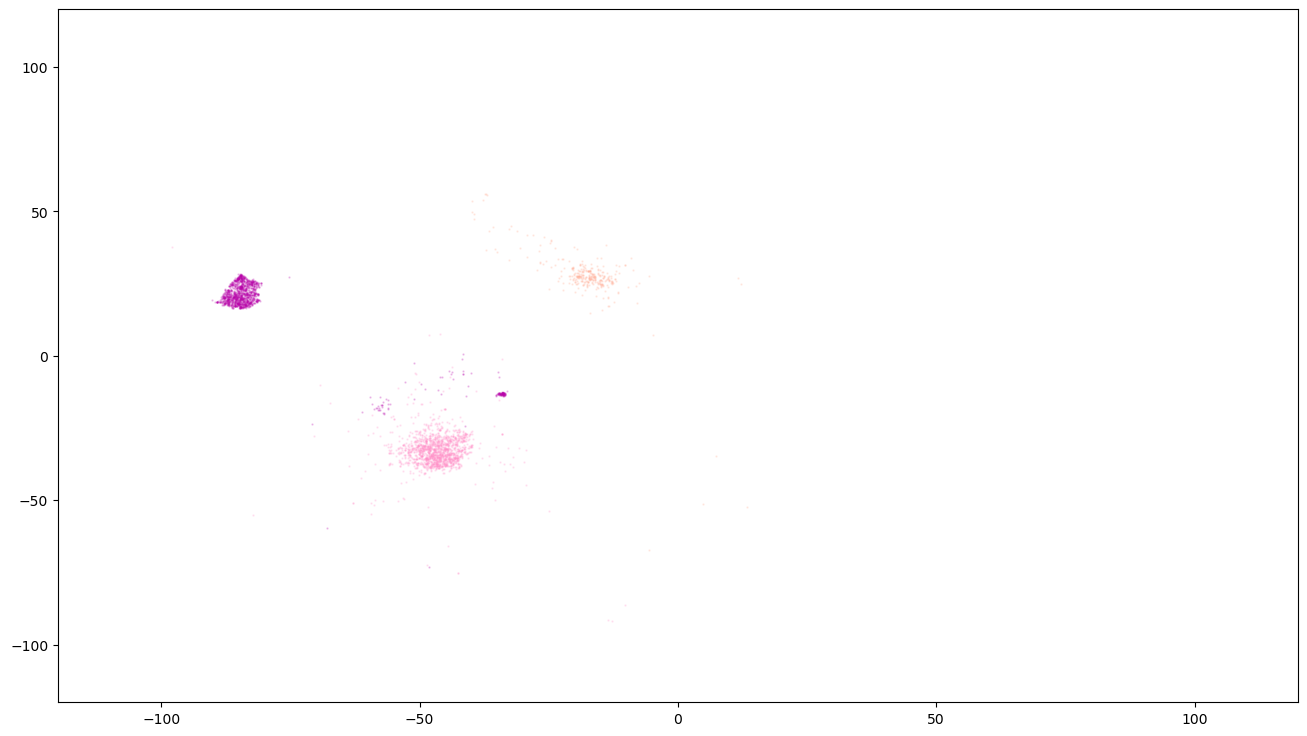

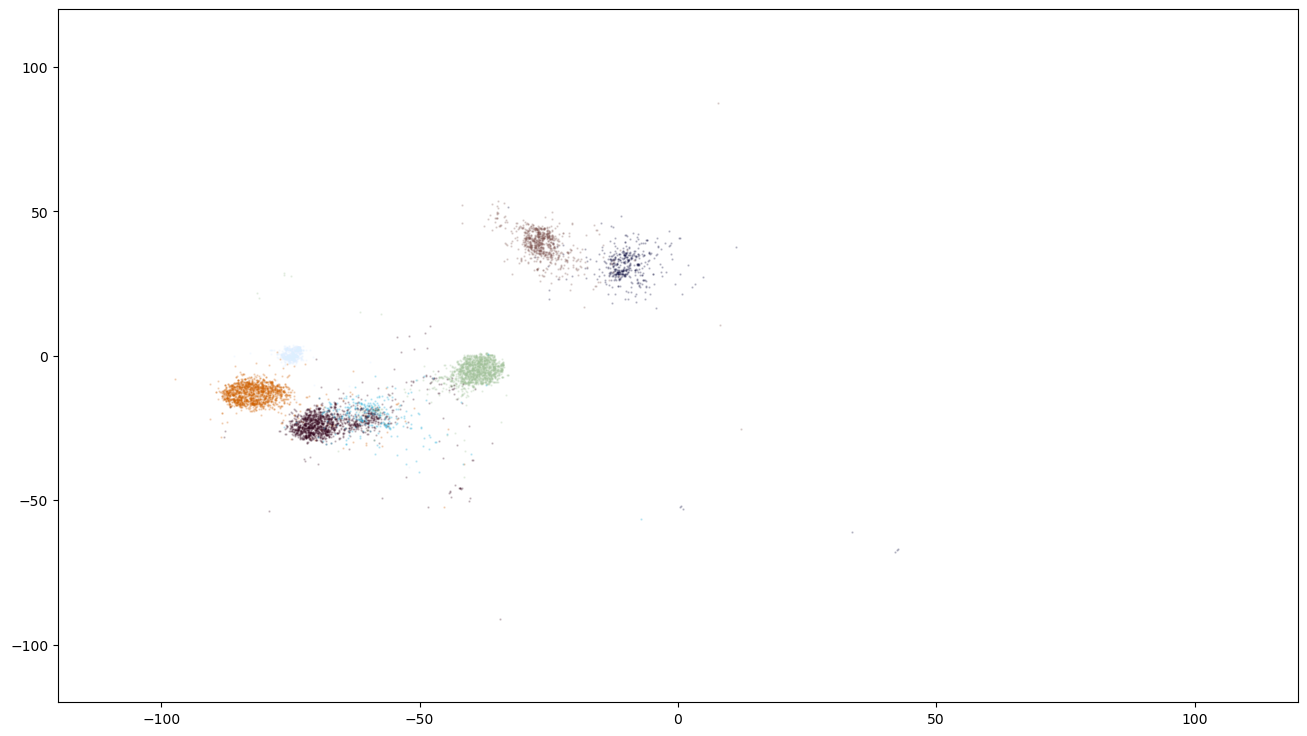

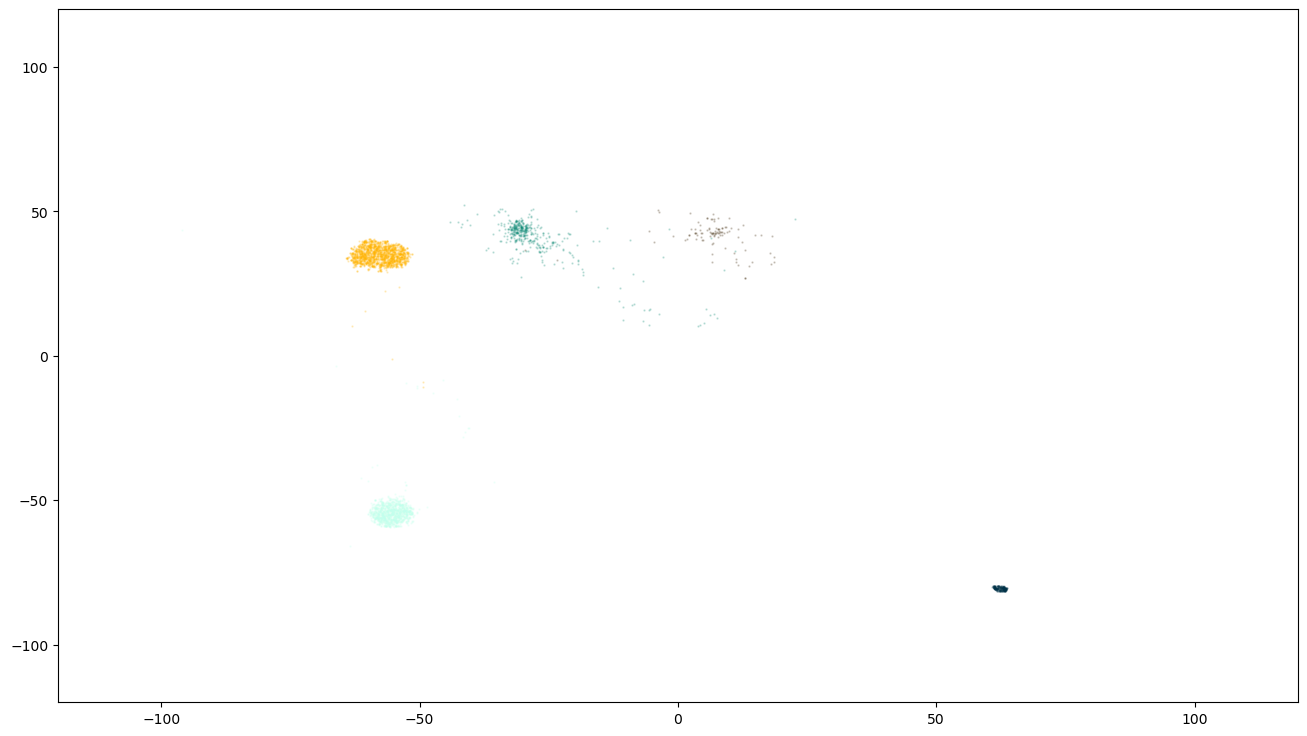

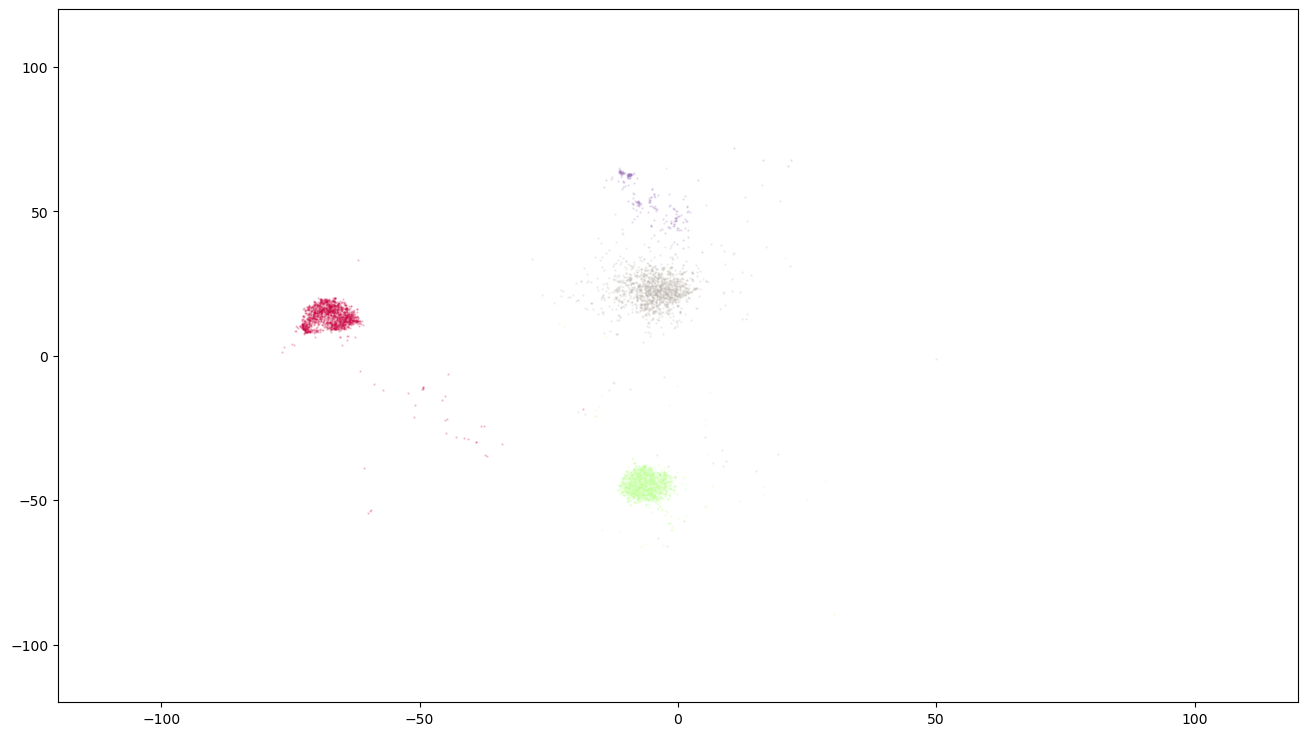

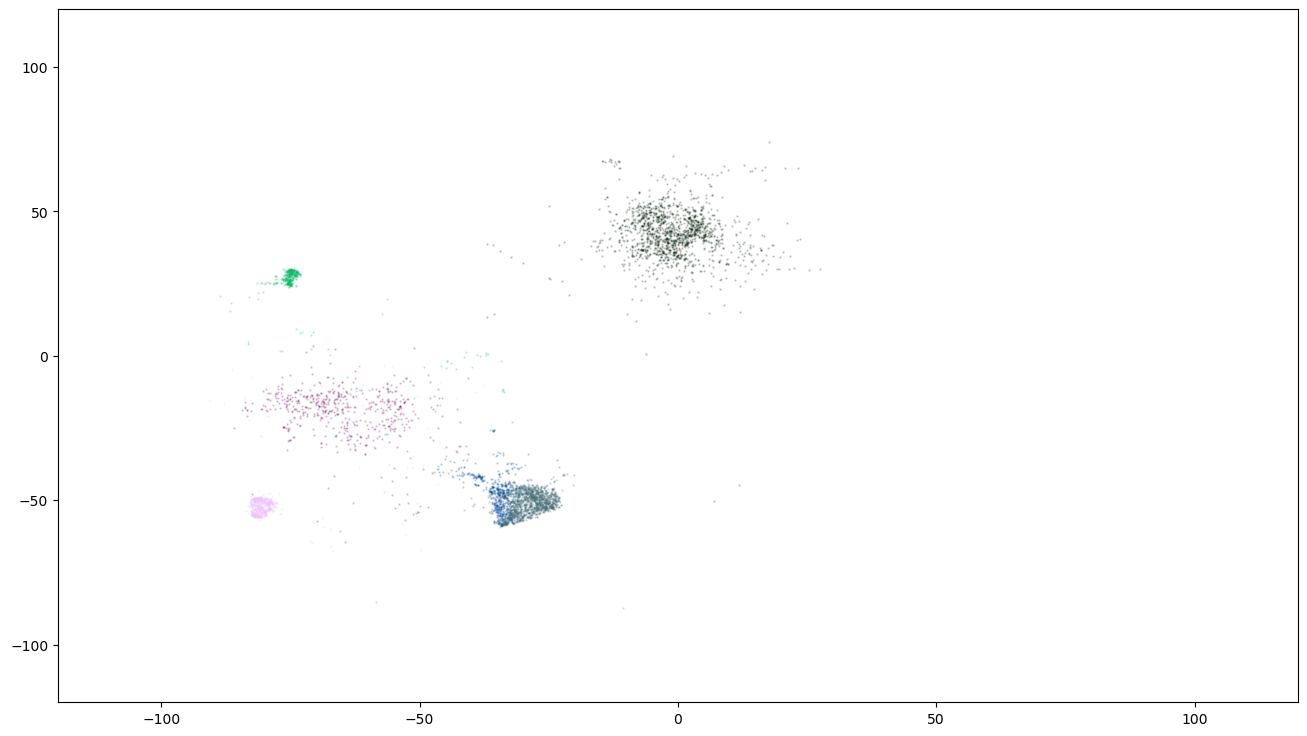

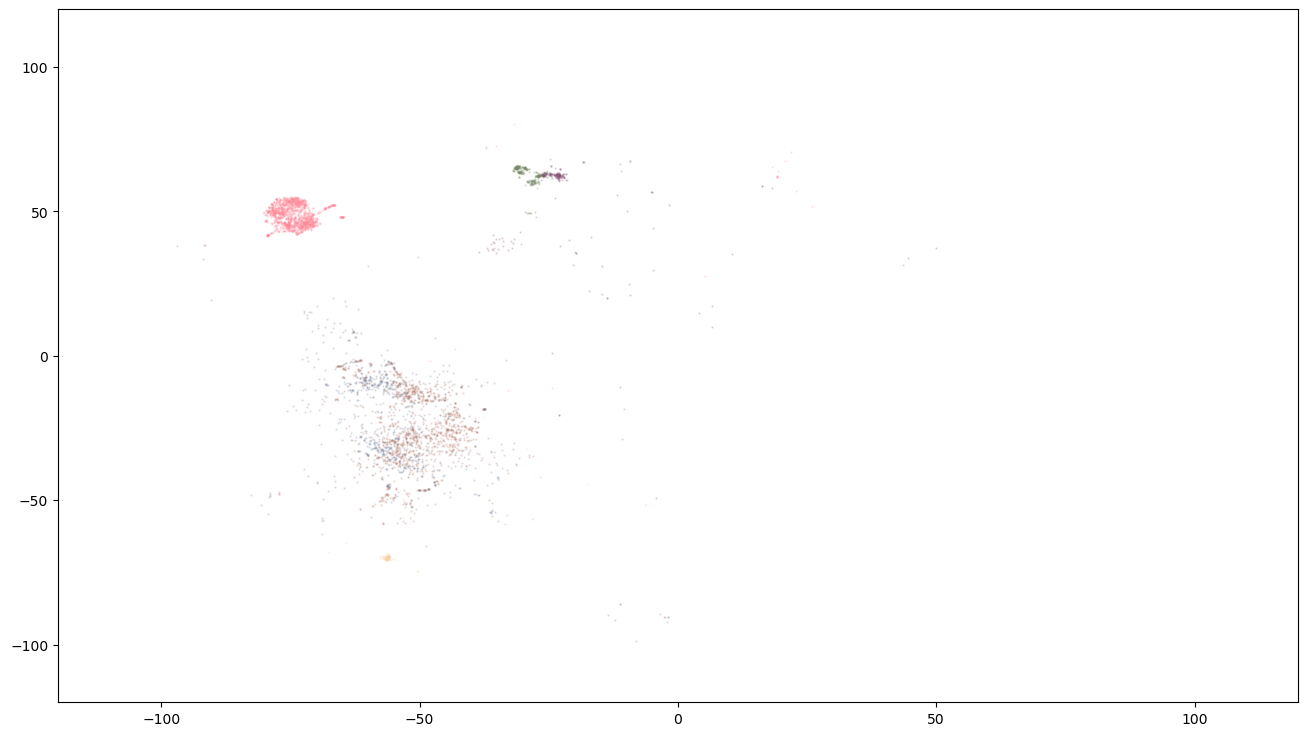

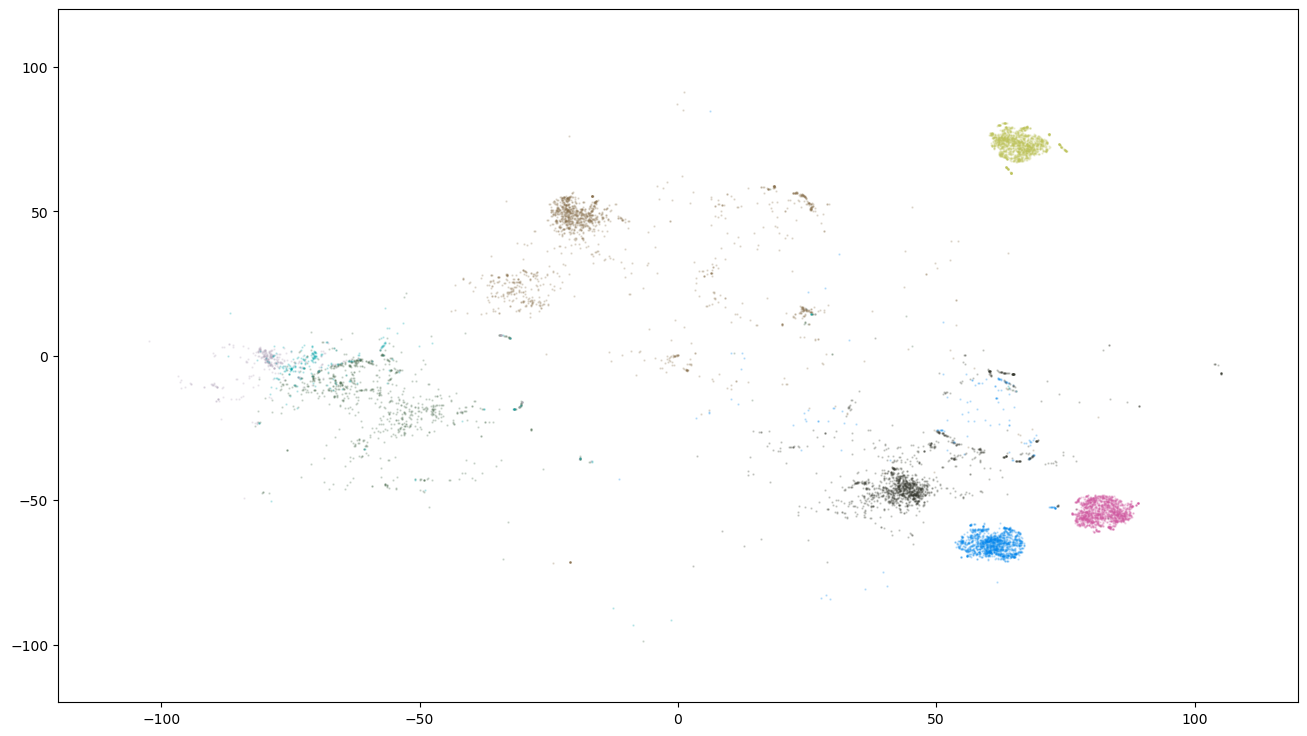

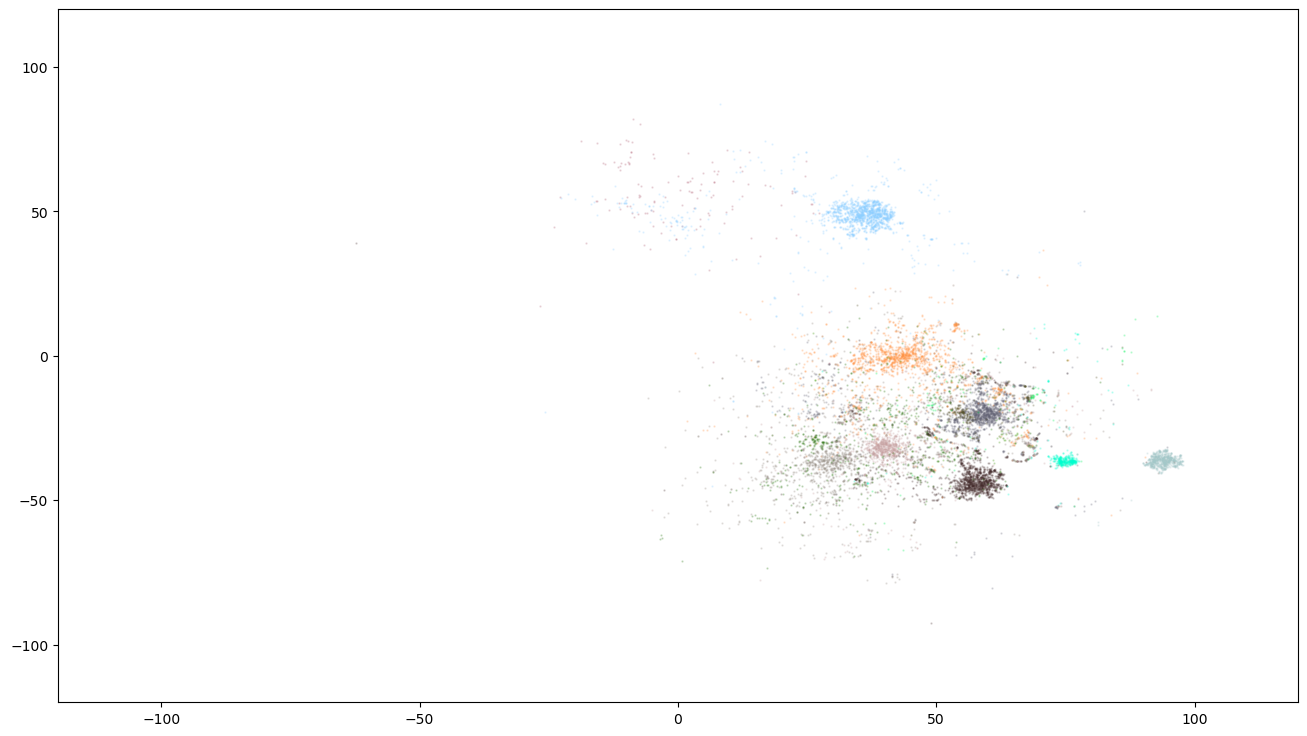

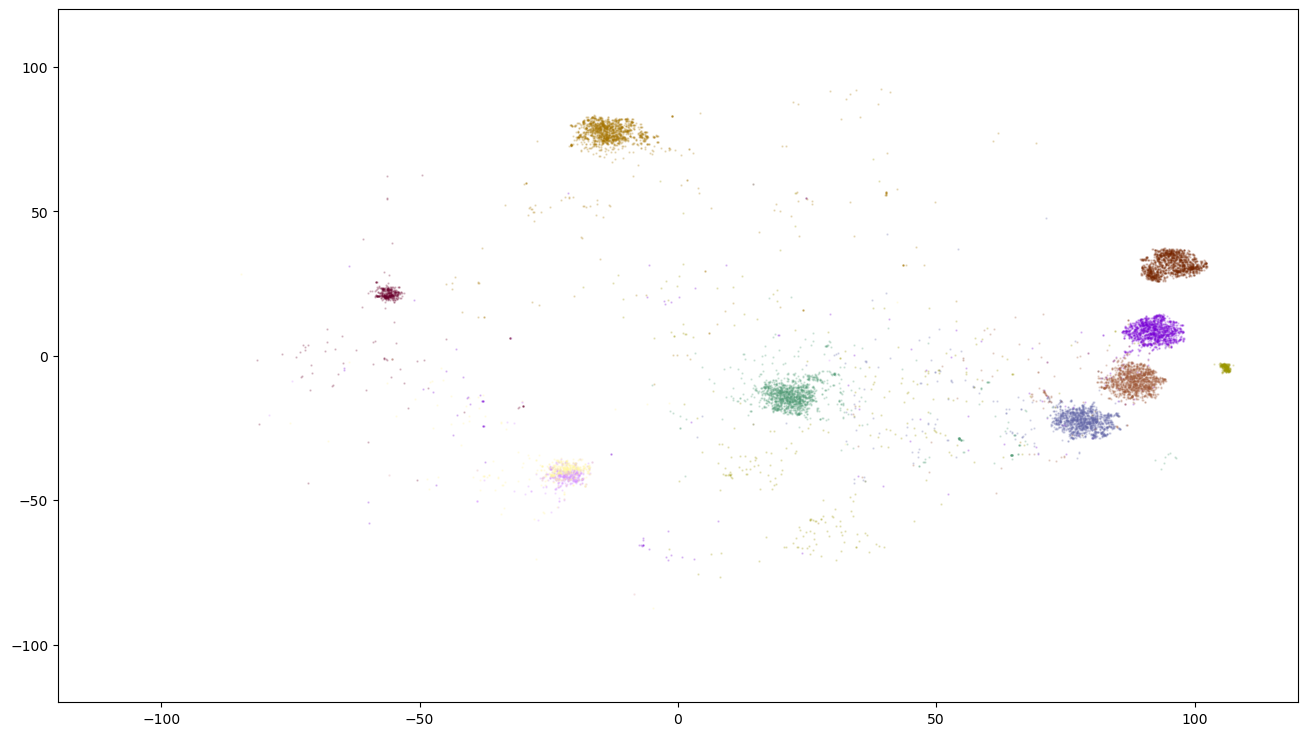

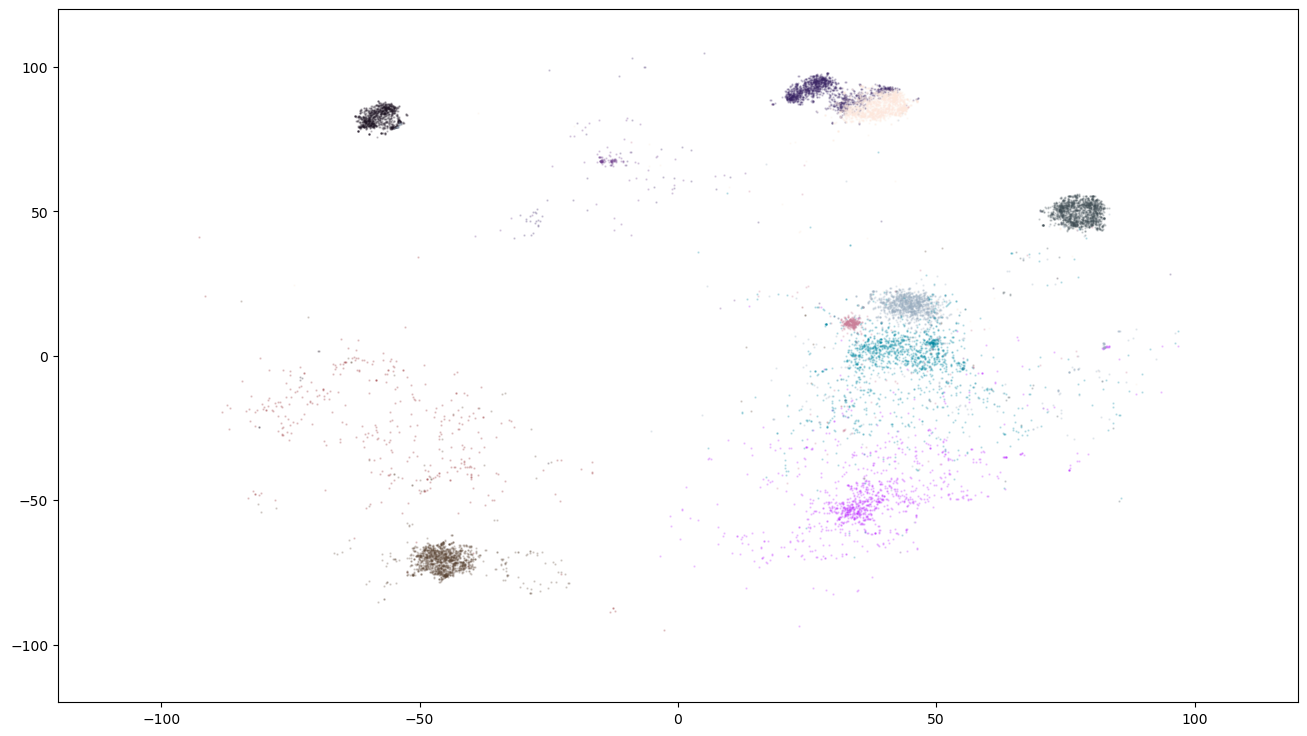

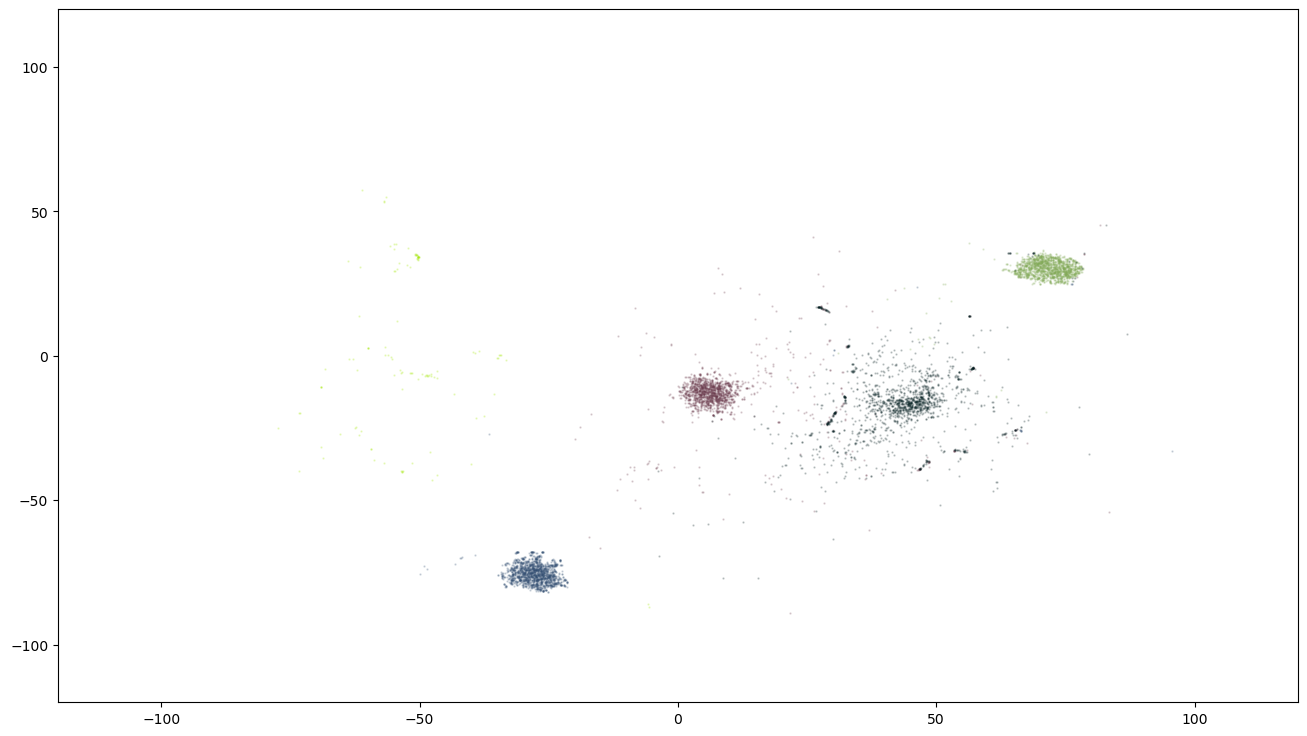

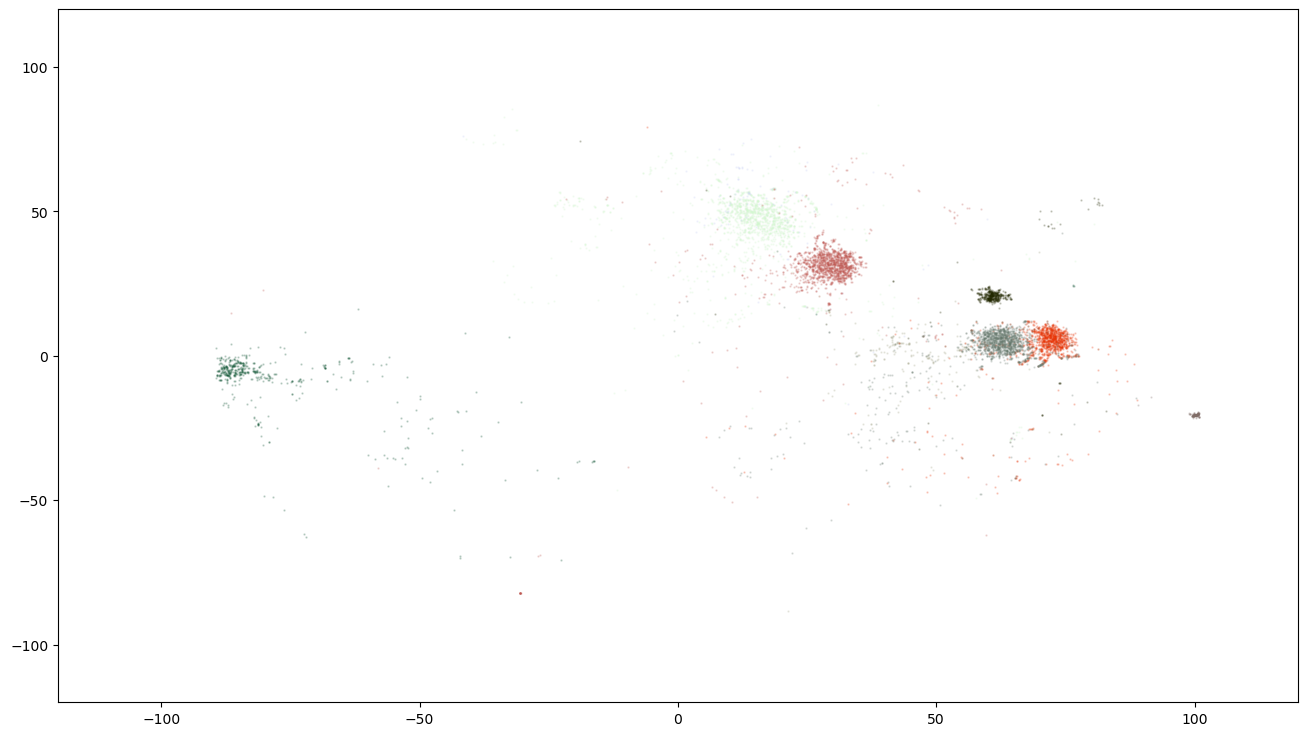

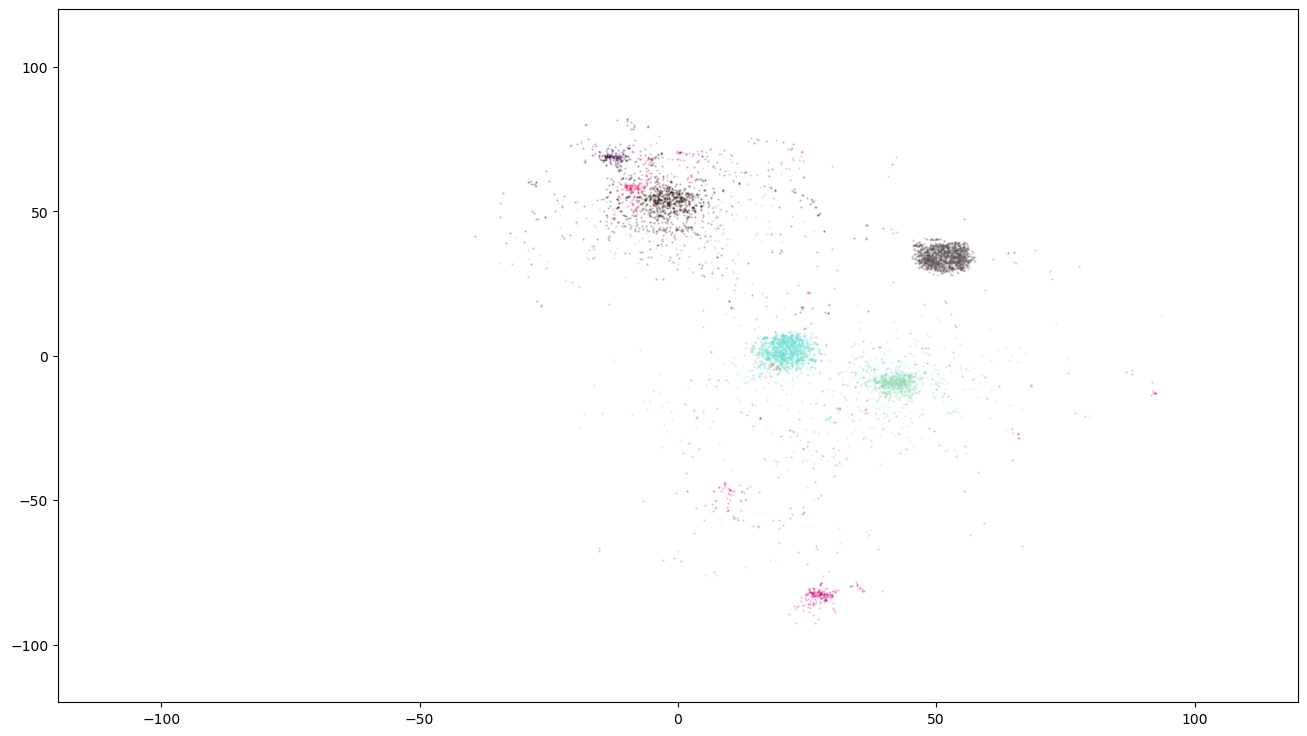

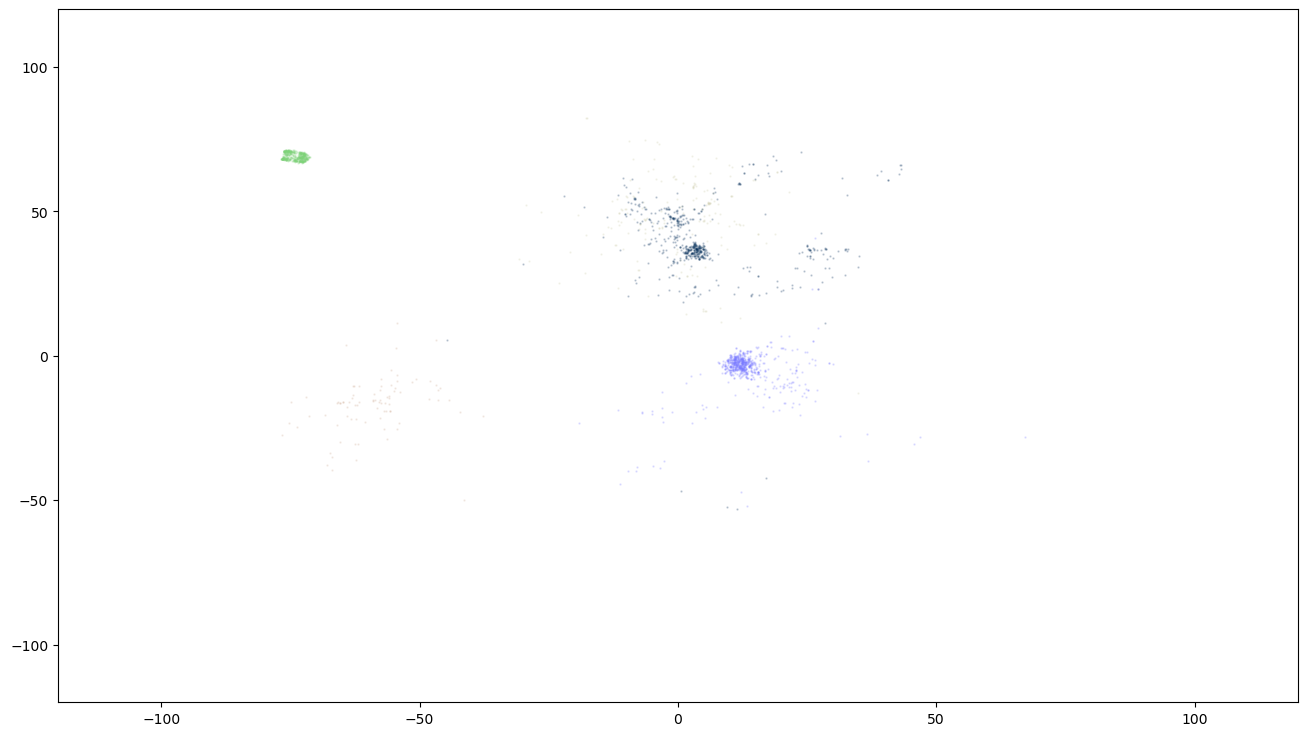

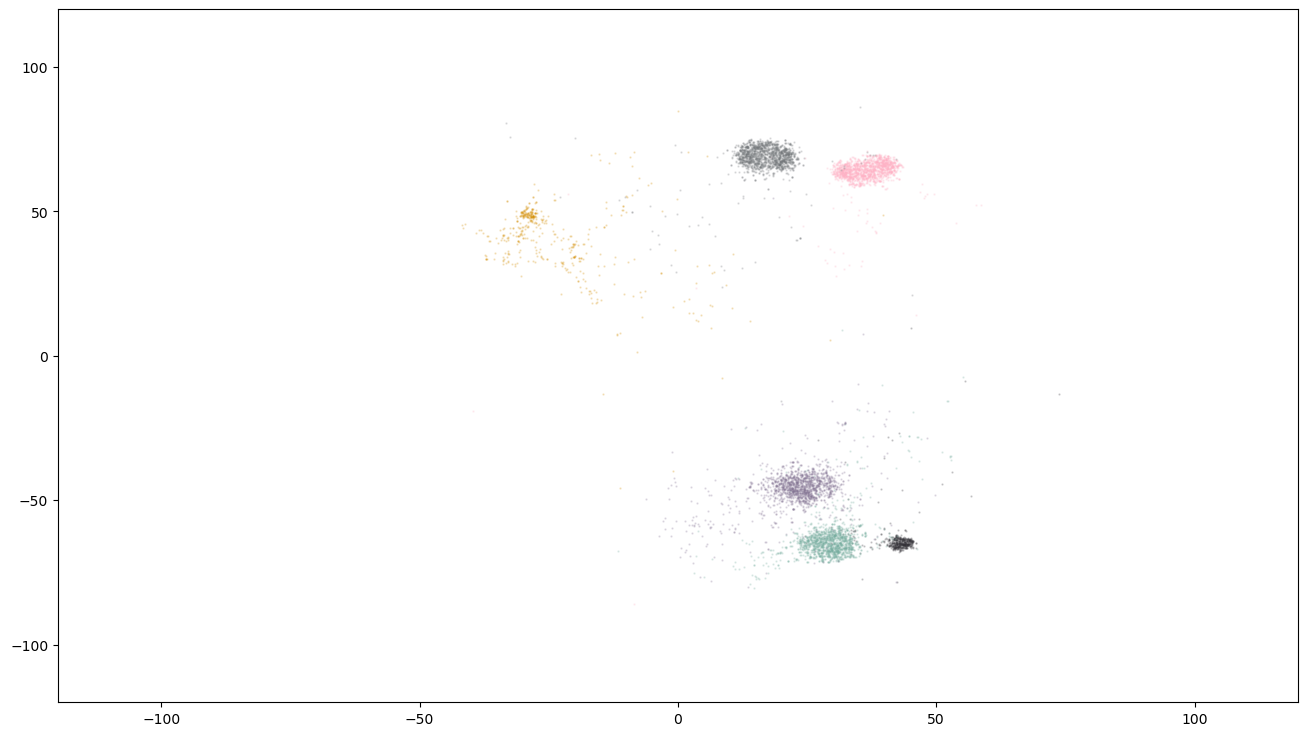

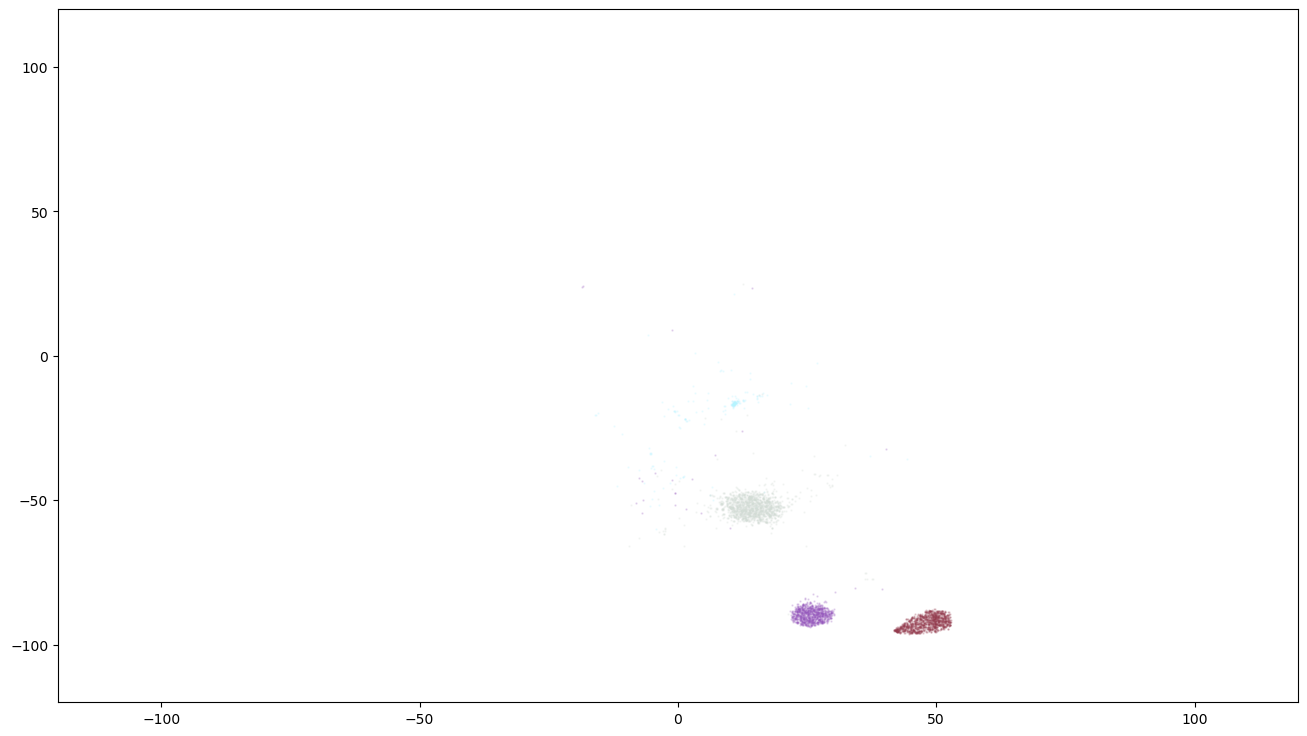

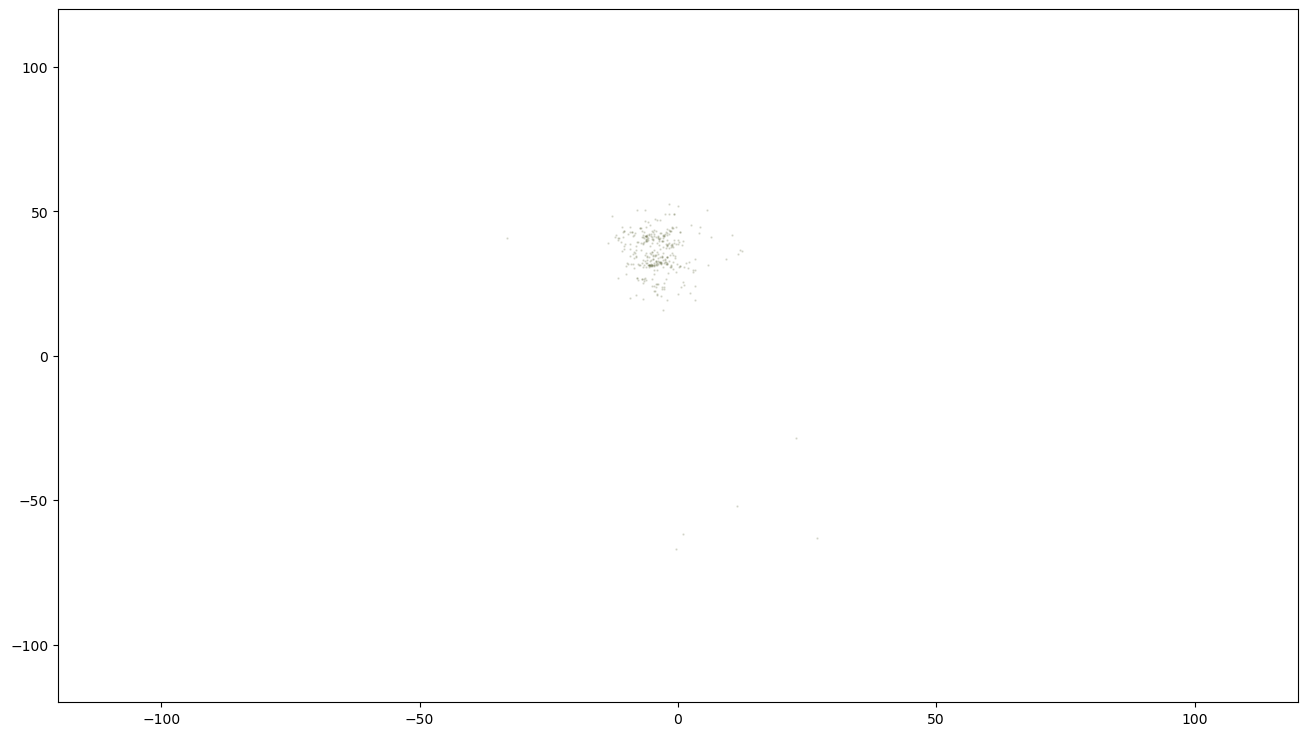

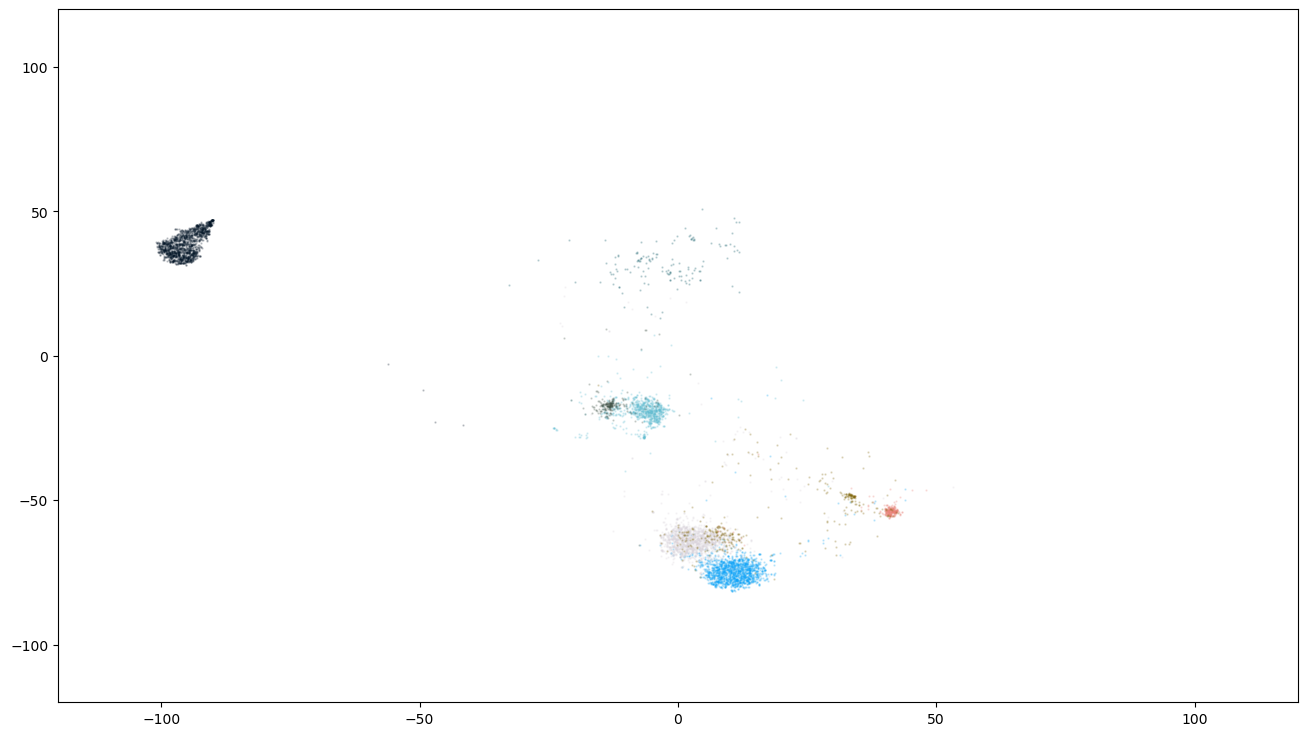

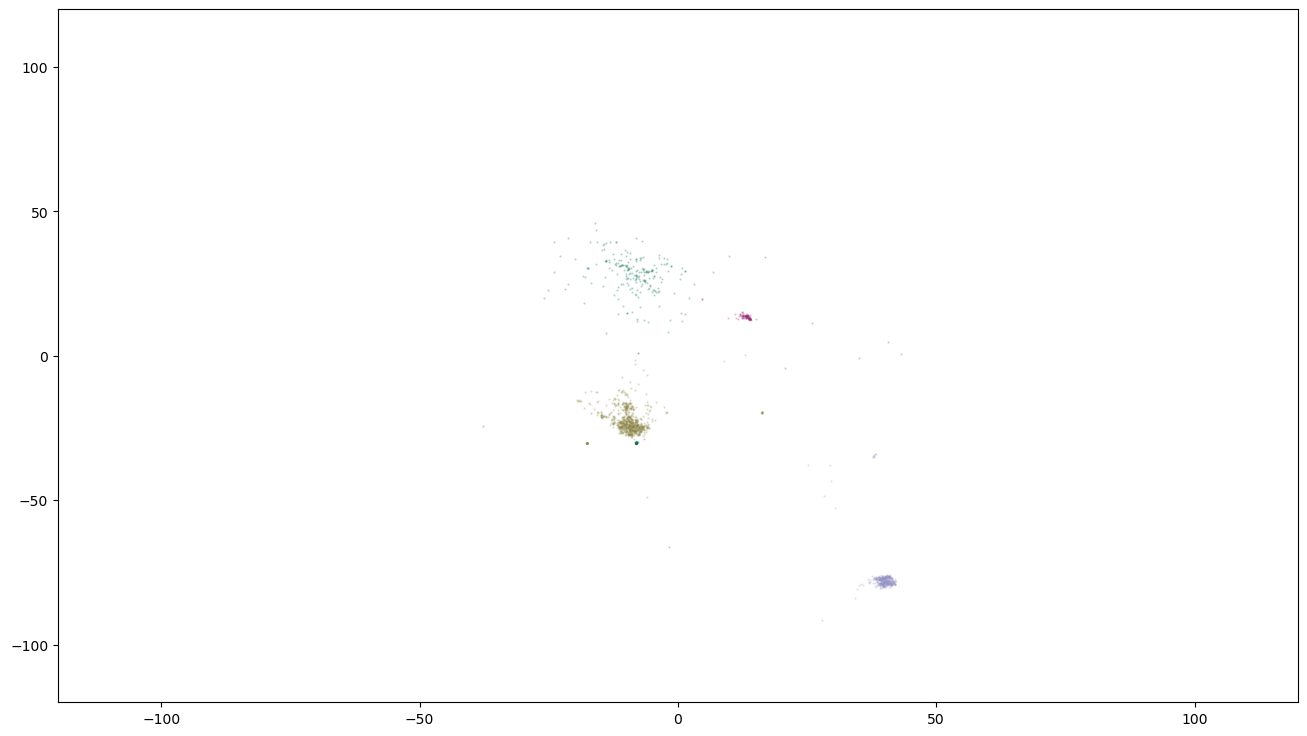

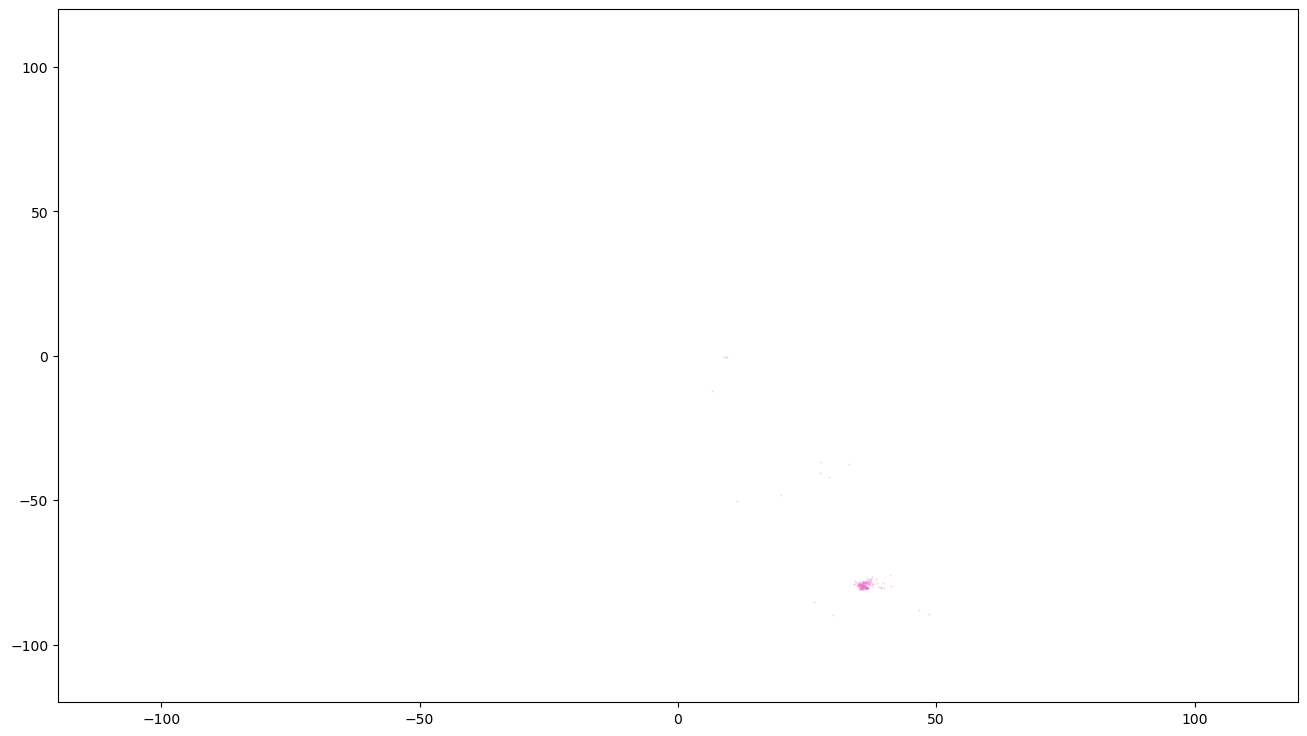

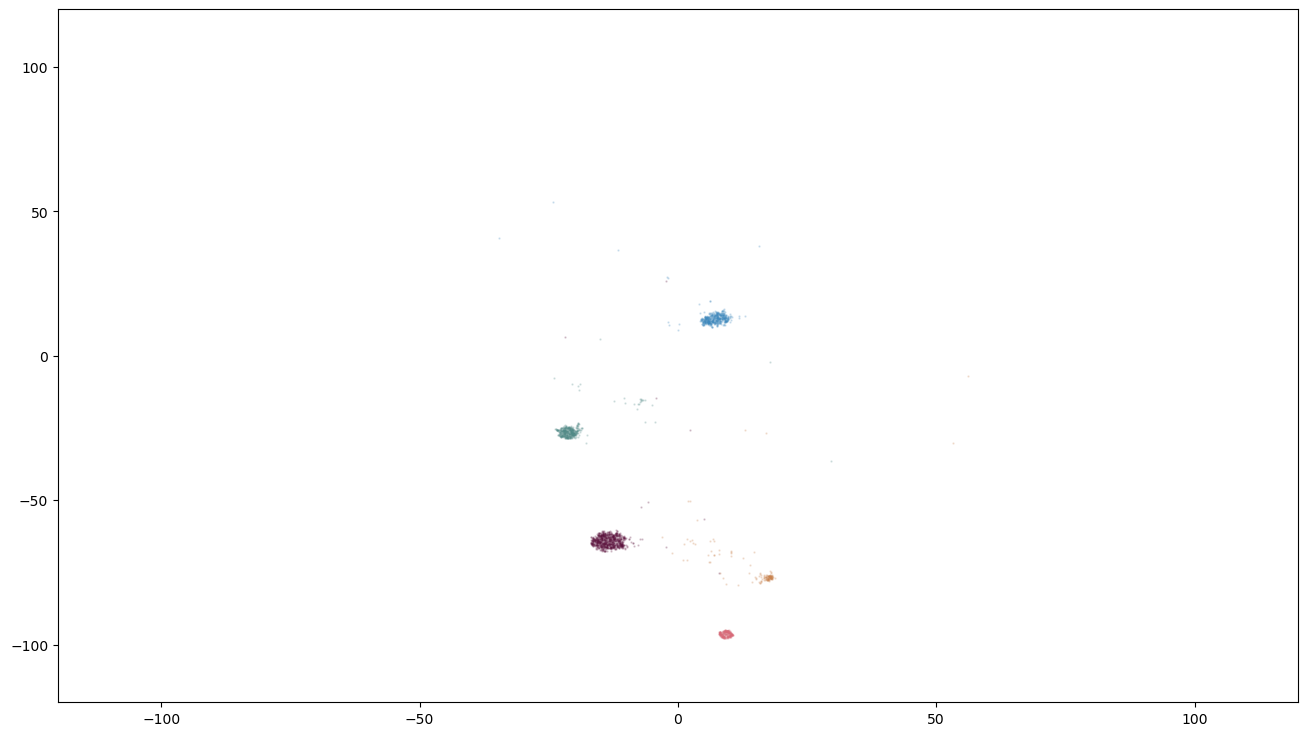

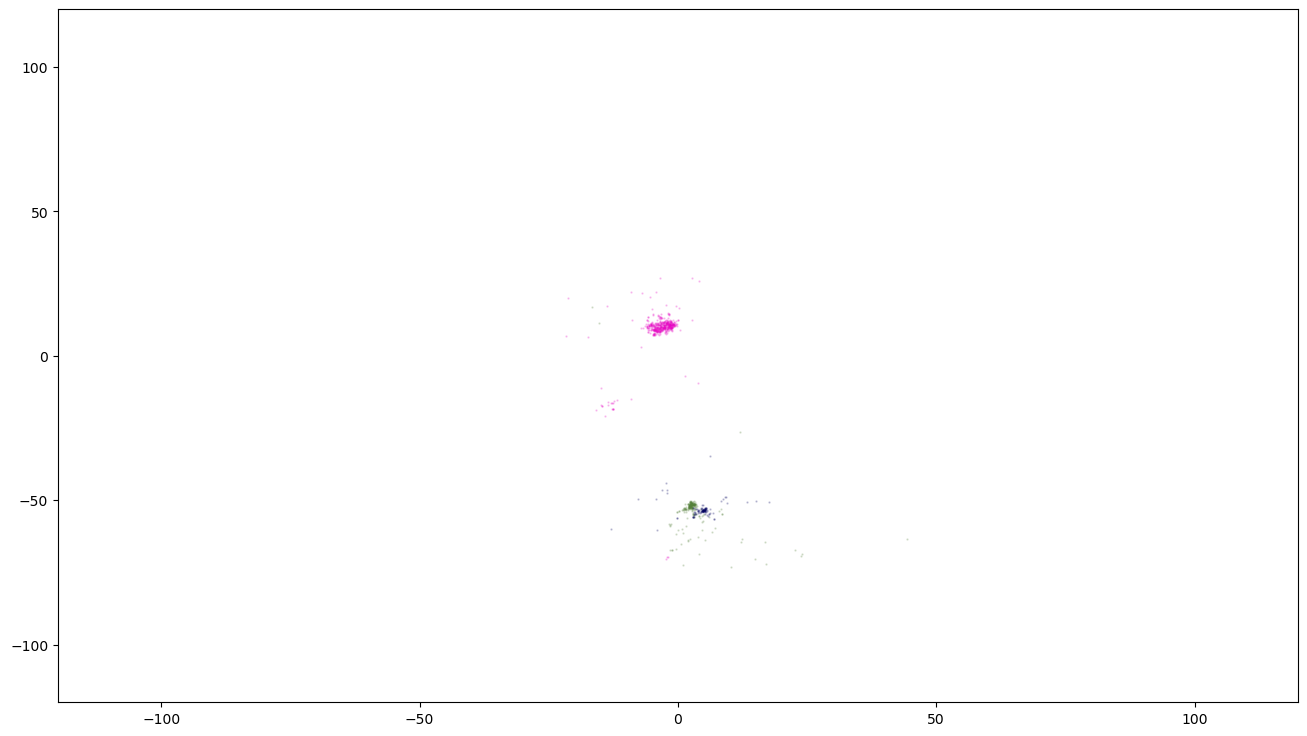

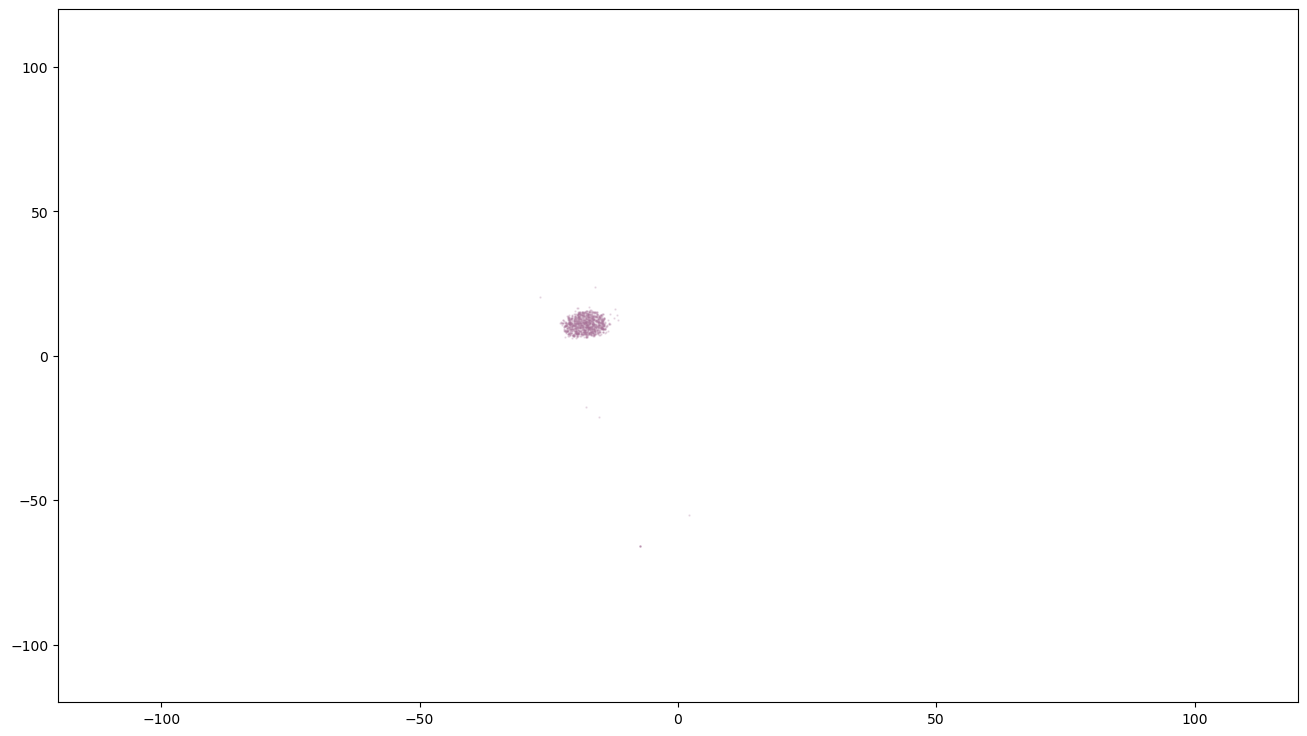

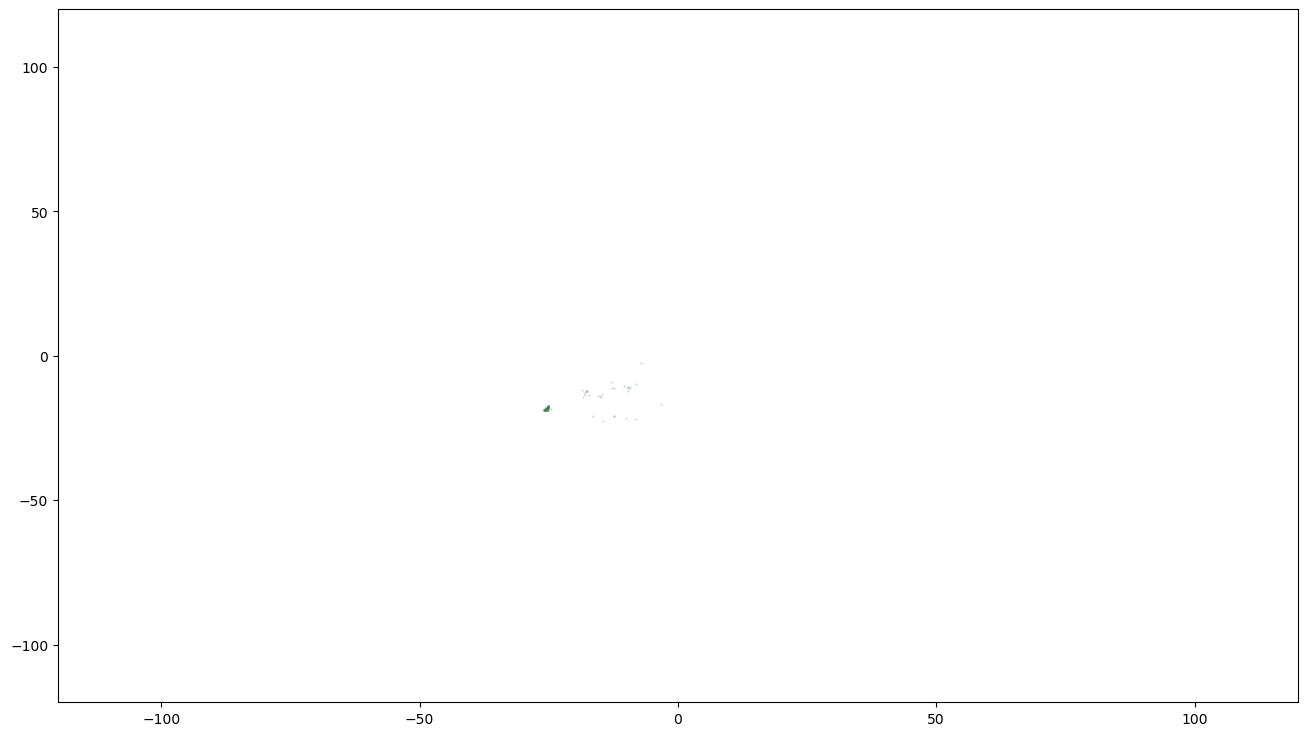

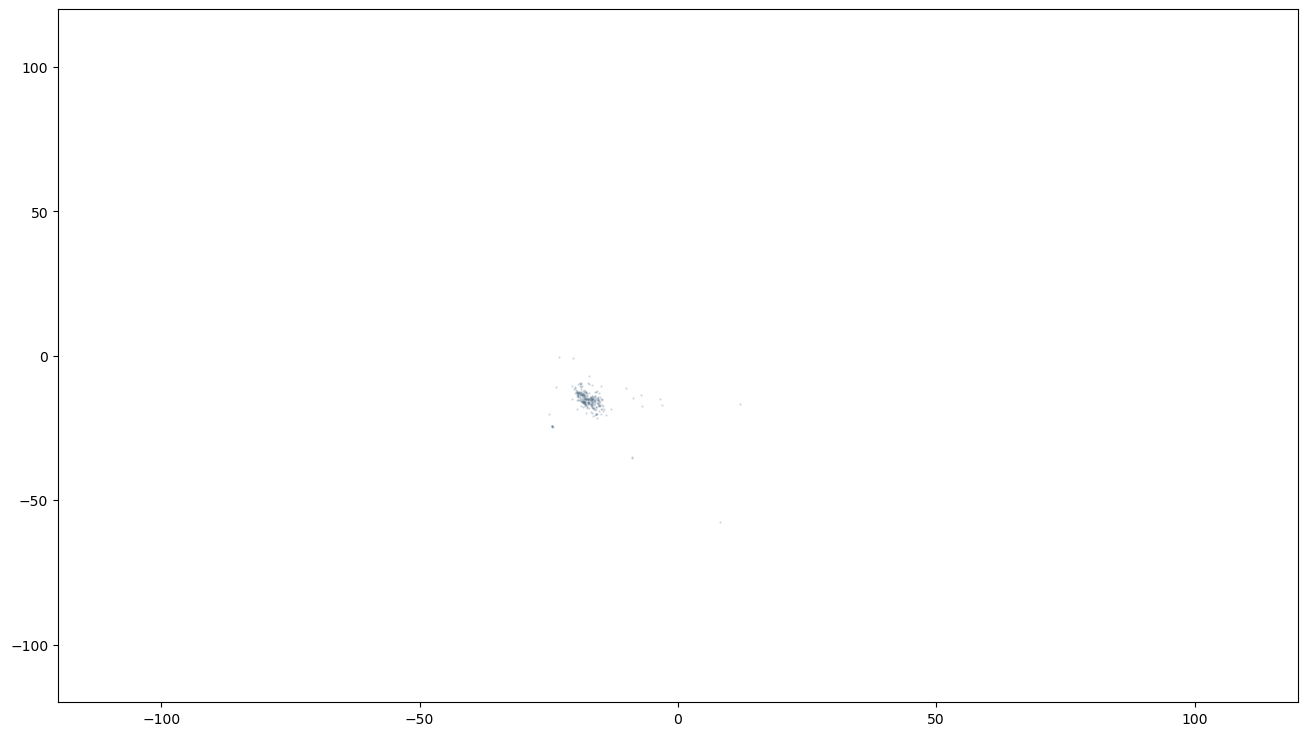

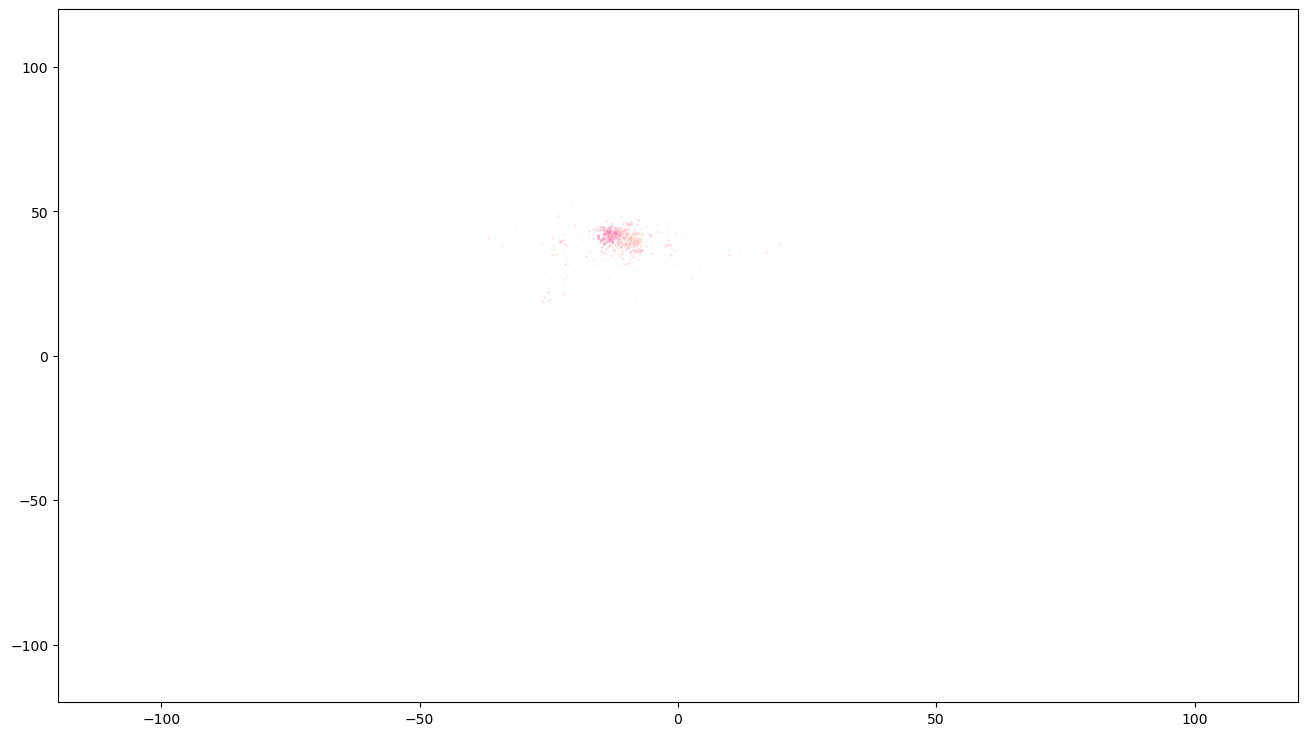

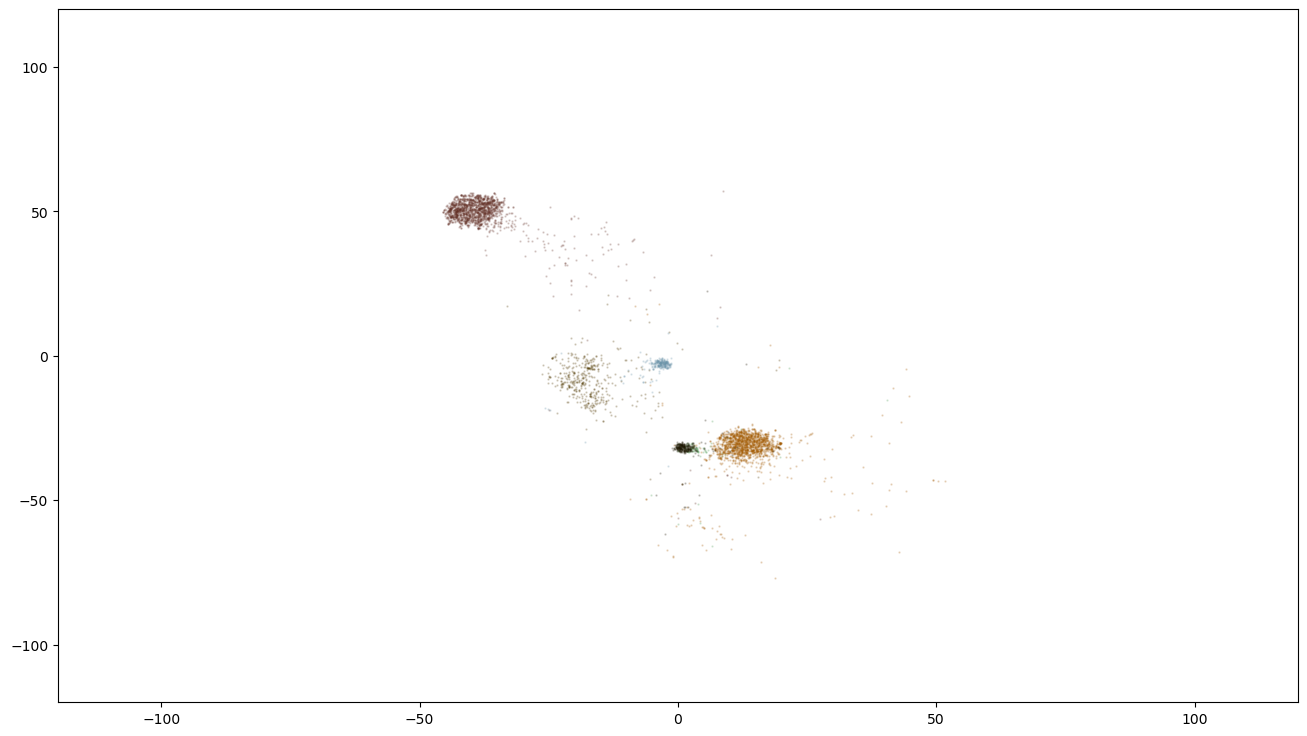

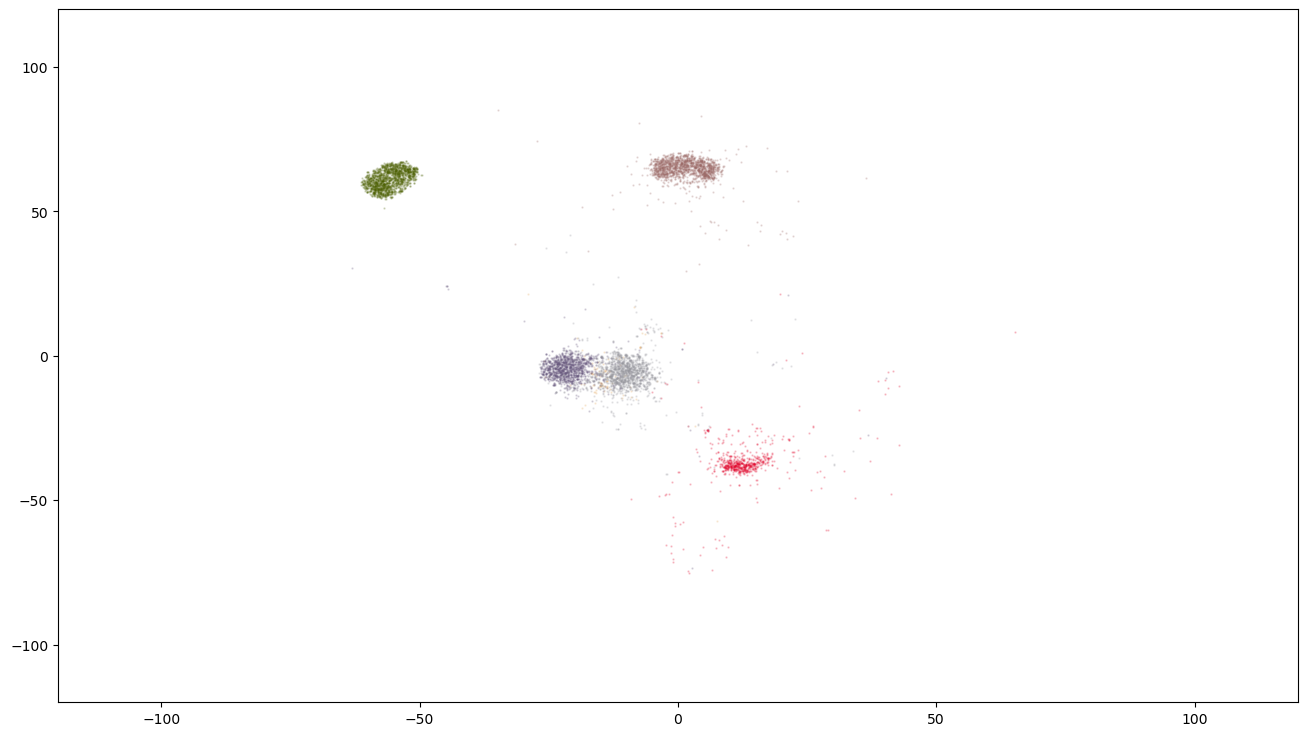

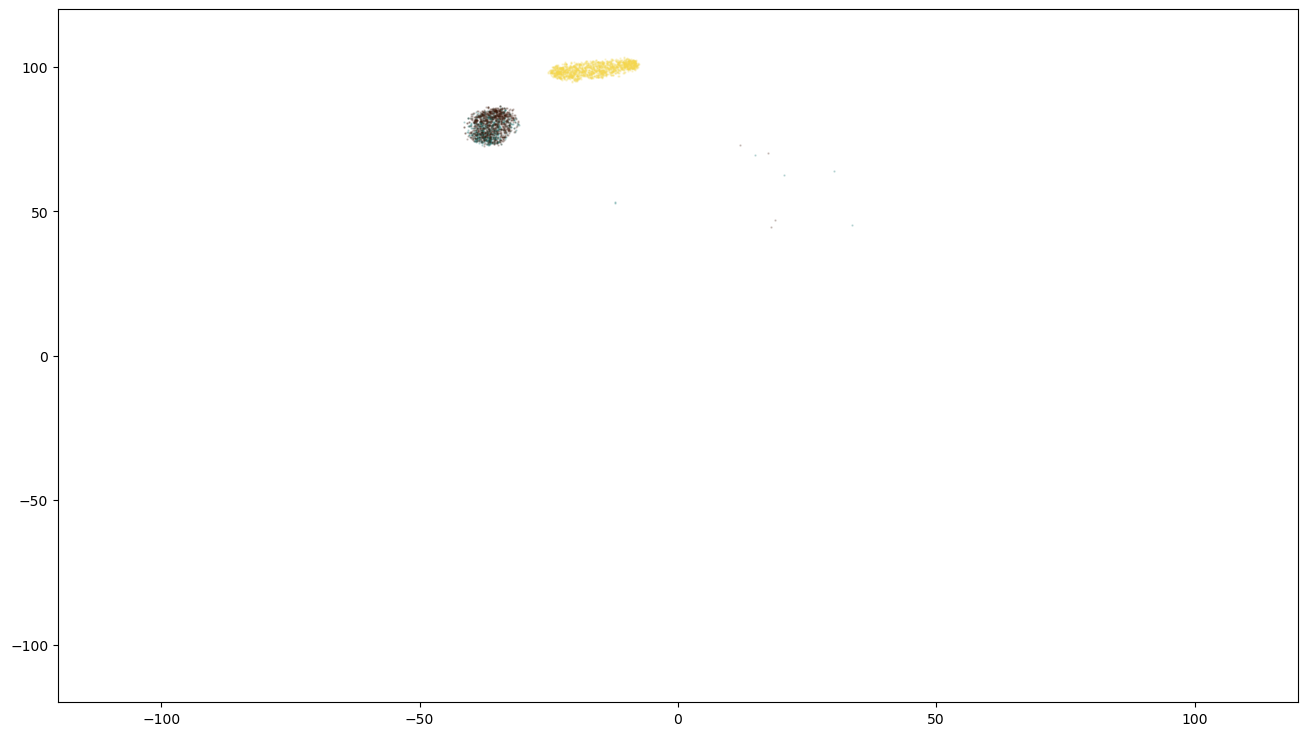

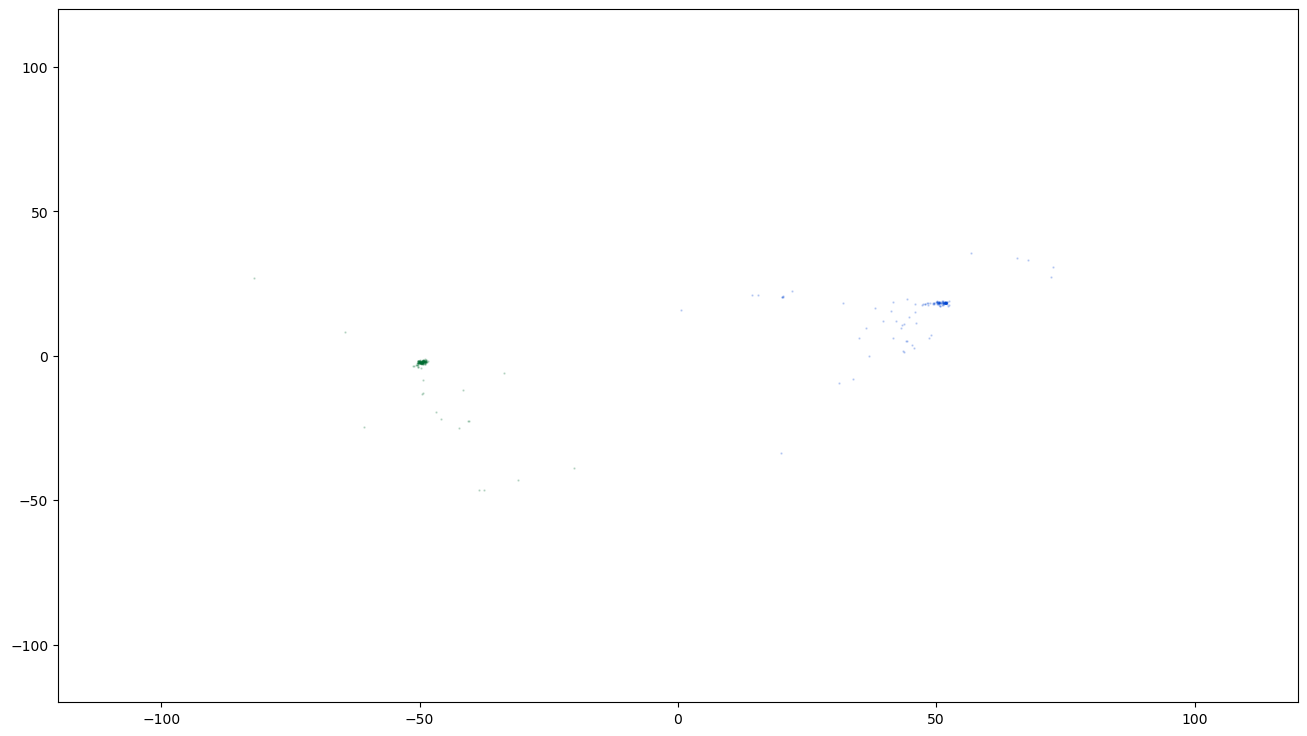

In [109]:
ind = 0
for chunk in ae_df.groupby('peak'):
    plt.figure(figsize=(16,9))
    for group in chunk[1].groupby('cl'):
        plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=ind, color=colors[ind], alpha=.2); 
        ind += 1
    plt.ylim([-120, 120]); plt.xlim([-120, 120])

    # plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Kilosort cluster")

In [81]:
train_data = train_data.squeeze().reshape(-1,320).cpu().detach().numpy()

In [82]:
pca = PCA(n_components=15)
pca_feat = pca.fit_transform(train_data)

tsne_pca = TSNE(n_components = 2)
pca_tsne = tsne_pca.fit_transform(pca_feat)

In [83]:
pca_df = pd.DataFrame({'tsne_1': pca_tsne[:,0], 'tsne_2': pca_tsne[:,1], 'cl': pca_lab})

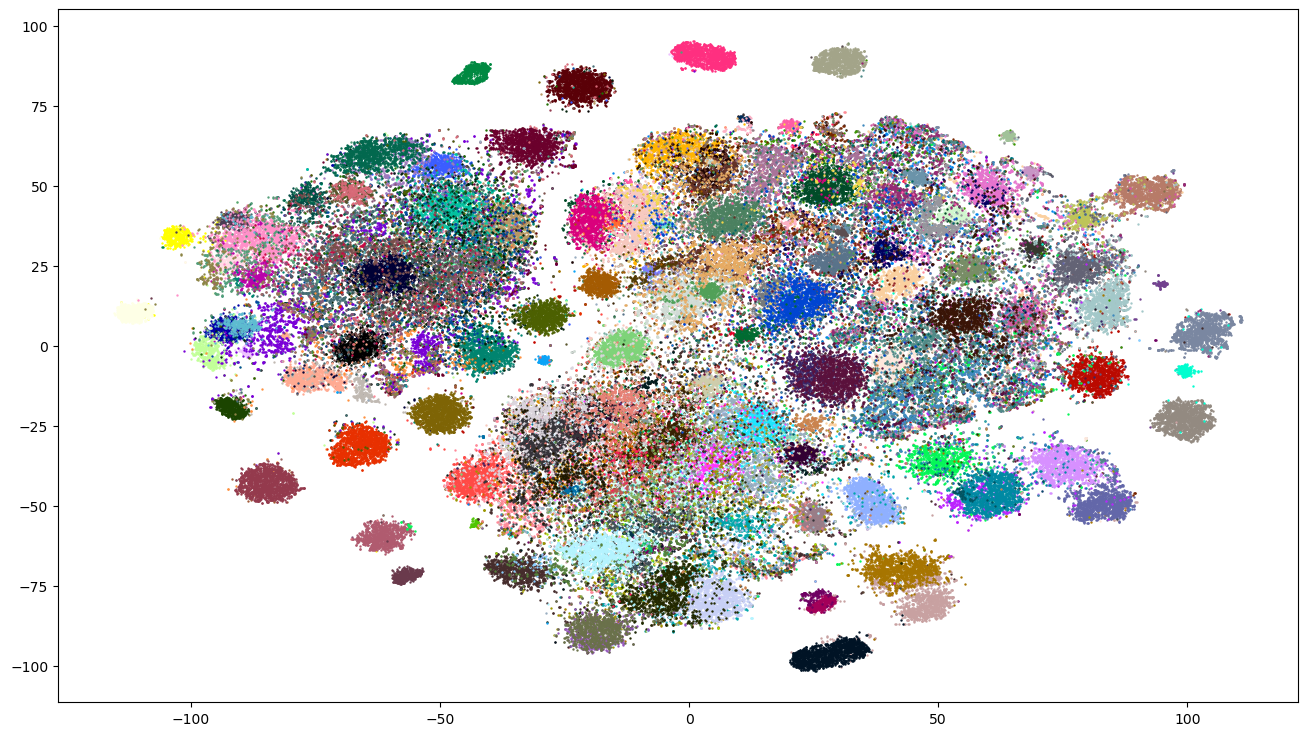

In [84]:
plt.figure(figsize=(16,9))
ind = 0
for group in pca_df.groupby('cl'):
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=ind, color=colors[ind]); 
    ind += 1

## TSNE from Higher-D AE

In [93]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 10
test_loss = np.zeros(10)

"""
Initialize the network and the Adam optimizer
"""
net = CN_AE(zDim=100).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    print('EPOCH %d' % (epoch))
    running_loss = 0
    last_loss = 0
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out = net(imgs)
        loss = loss_fn(out, imgs)
        
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Gather data and report
        running_loss += loss
        if idx % 500 == 499:
            last_loss = running_loss/500
            print(" Batch %d | loss: %.4f" % (idx, last_loss))
            running_loss = 0
        
    print()
    # test error
    running_tloss = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print("\r" + str(i), end="")
            imgs, _ = data
            imgs = imgs.to(device)
            
            out = net(imgs)
            tloss = loss_fn(out, imgs)
            running_tloss += tloss
        
    avg_vloss = running_tloss/(i+1)
    test_loss[epoch] = avg_vloss
    
    print("\nLOSS | train: %.4f | test %.4f" % (last_loss, avg_vloss))

EPOCH 0
499 Batch 499 | loss: 36.5439
999 Batch 999 | loss: 19.8848
1253
313
LOSS | train: 19.8848 | test 14.4250
EPOCH 1
499 Batch 499 | loss: 42.1441
999 Batch 999 | loss: 23.9895
1253
313
LOSS | train: 23.9895 | test 19.8437
EPOCH 2
499 Batch 499 | loss: 17.8453
999 Batch 999 | loss: 15.6292
1253
313
LOSS | train: 15.6292 | test 14.3478
EPOCH 3
499 Batch 499 | loss: 13.3298
999 Batch 999 | loss: 12.4625
1253
313
LOSS | train: 12.4625 | test 11.9034
EPOCH 4
499 Batch 499 | loss: 11.4972
999 Batch 999 | loss: 11.1041
1253
313
LOSS | train: 11.1041 | test 10.7016
EPOCH 5
499 Batch 499 | loss: 10.4677
999 Batch 999 | loss: 10.1808
1253
313
LOSS | train: 10.1808 | test 9.8490
EPOCH 6
499 Batch 499 | loss: 9.7630
999 Batch 999 | loss: 9.5318
1253
313
LOSS | train: 9.5318 | test 9.2598
EPOCH 7
499 Batch 499 | loss: 9.2067
999 Batch 999 | loss: 9.0506
1253
313
LOSS | train: 9.0506 | test 8.6933
EPOCH 8
499 Batch 499 | loss: 8.7042
999 Batch 999 | loss: 8.5798
1253
313
LOSS | train: 8.5798 |

In [95]:
train_lat = np.zeros((len(train_indices), 100))

with torch.no_grad():
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)
        
        out = net.encoder(imgs)
        train_lat[128*idx:(idx+1)*128,:] = out.cpu().detach().numpy()

1253

In [96]:
tsne = TSNE(n_components = 2)
lat_tsne = tsne.fit_transform(train_lat)

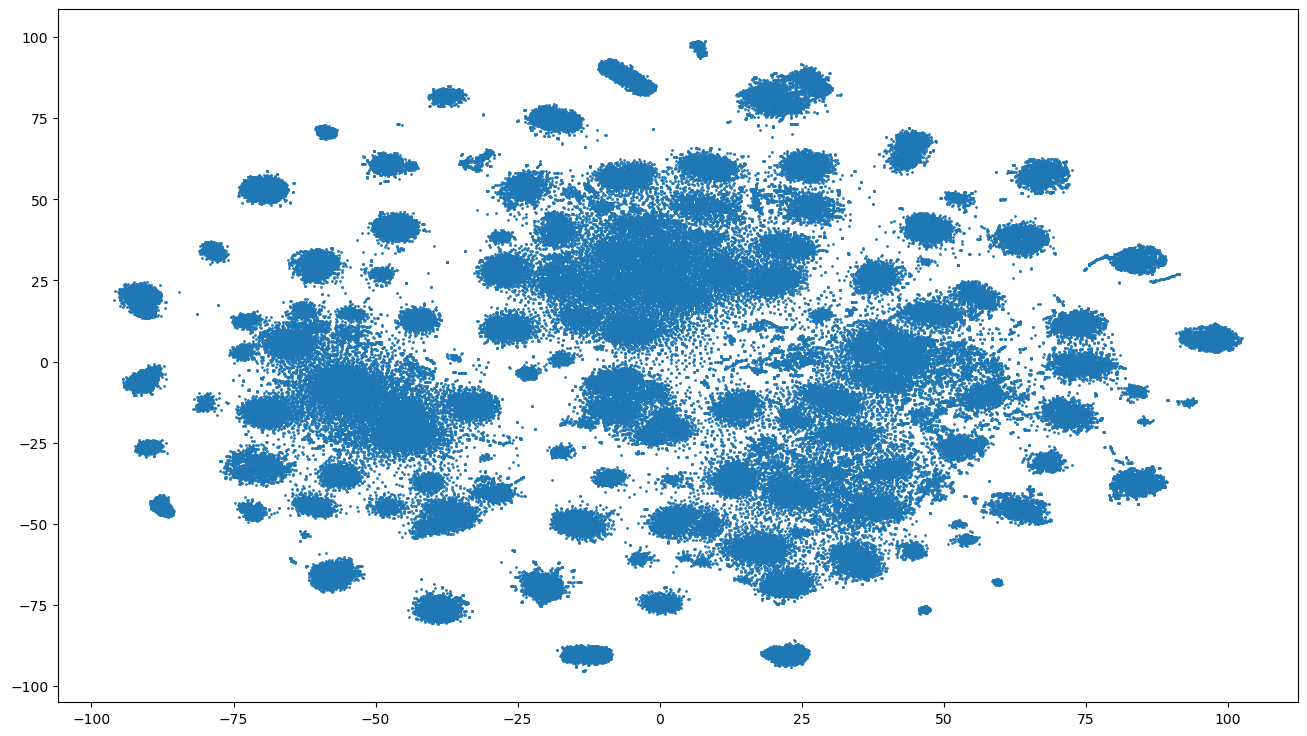

In [97]:
plt.figure(figsize=(16,9))
plt.scatter(lat_tsne[:,0],lat_tsne[:,1], s=1);

## Skip Connections

In [83]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 10
test_loss = np.zeros(10)

"""
Initialize the network and the Adam optimizer
"""
net = CNS_AE(zDim=15).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    print('EPOCH %d' % (epoch))
    running_loss = 0
    last_loss = 0
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out = net(imgs)
        loss = loss_fn(out, imgs)
        
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Gather data and report
        running_loss += loss
        if idx % 500 == 499:
            last_loss = running_loss/500
            print(" Batch %d | loss: %.4f" % (idx, last_loss))
            running_loss = 0
        
    print()
    # test error
    running_tloss = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print("\r" + str(i), end="")
            imgs, _ = data
            imgs = imgs.to(device)
            
            out = net(imgs)
            tloss = loss_fn(out, imgs)
            running_tloss += tloss
        
    avg_vloss = running_tloss/(i+1)
    test_loss[epoch] = avg_vloss
    
    print("\nLOSS | train: %.4f | test %.4f" % (last_loss, avg_vloss))

EPOCH 0
499 Batch 499 | loss: 2.3114
999 Batch 999 | loss: 0.4875
1253
313
LOSS | train: 0.4875 | test 0.1328
EPOCH 1
499 Batch 499 | loss: 0.0388
999 Batch 999 | loss: 0.0256
1253
313
LOSS | train: 0.0256 | test 0.0197
EPOCH 2
499 Batch 499 | loss: 0.0204
999 Batch 999 | loss: 0.0172
1253
313
LOSS | train: 0.0172 | test 0.0120
EPOCH 3
499 Batch 499 | loss: 0.0125
999 Batch 999 | loss: 0.0163
1253
313
LOSS | train: 0.0163 | test 0.0080
EPOCH 4
499 Batch 499 | loss: 0.0122
999 Batch 999 | loss: 0.0090
1253
313
LOSS | train: 0.0090 | test 0.0054
EPOCH 5
499 Batch 499 | loss: 0.0092
999 Batch 999 | loss: 0.0076
1253
313
LOSS | train: 0.0076 | test 0.0063
EPOCH 6
499 Batch 499 | loss: 0.0071
999 Batch 999 | loss: 0.0052
1253
313
LOSS | train: 0.0052 | test 0.0040
EPOCH 7
499 Batch 499 | loss: 0.0049
999 Batch 999 | loss: 0.0067
1253
313
LOSS | train: 0.0067 | test 0.0035
EPOCH 8
499 Batch 499 | loss: 0.0035
999 Batch 999 | loss: 0.0042
1253
313
LOSS | train: 0.0042 | test 0.0099
EPOCH 9
49

In [84]:
train_lat = np.zeros((len(train_indices), 15))

with torch.no_grad():
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)
        
        out = net.encoder(imgs)
        train_lat[128*idx:(idx+1)*128,:] = out.cpu().detach().numpy()

1253

In [85]:
tsne = TSNE(n_components = 2)
lat_tsne = tsne.fit_transform(train_lat)

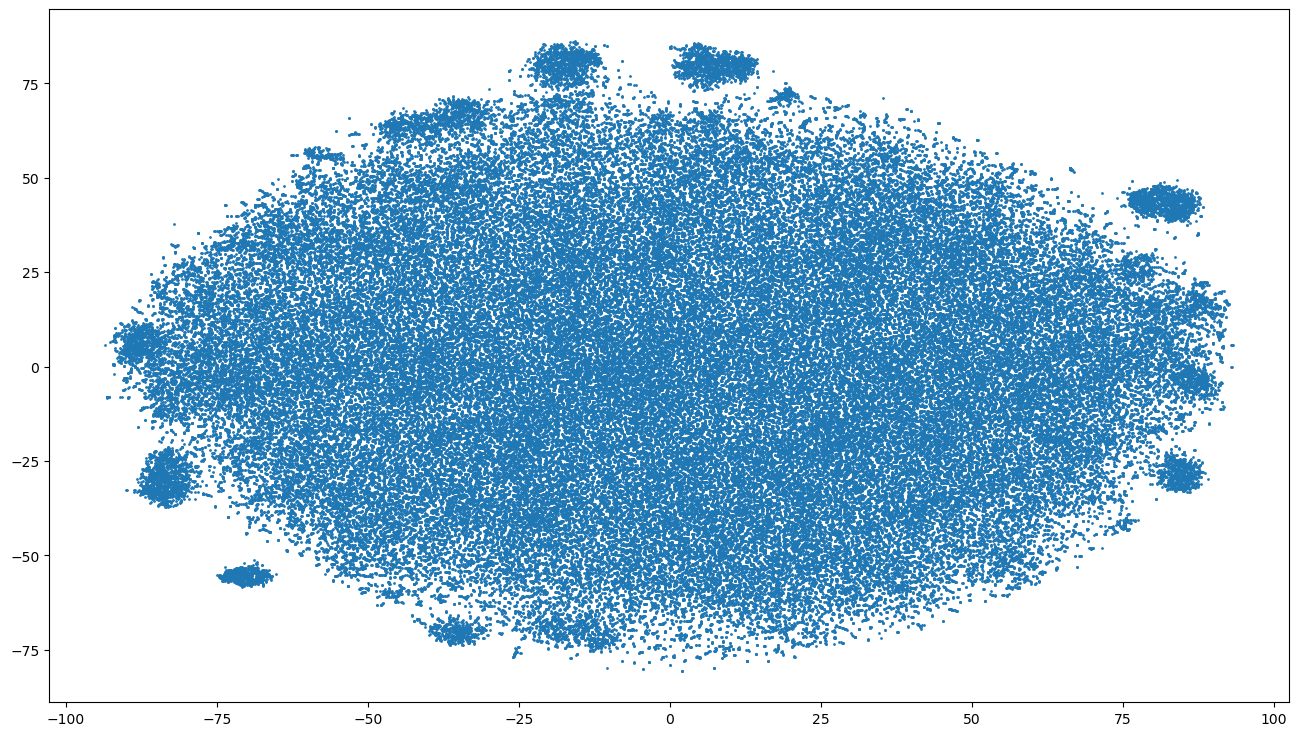

In [86]:
plt.figure(figsize=(16,9))
plt.scatter(lat_tsne[:,0],lat_tsne[:,1], s=1);

## Effect of Latent Dimensionality

In [ ]:
zdims = np.array([15, 20, 30])

learning_rate = 1e-3
num_epochs = 10

test_loss = np.zeros((zdims.shape[0], num_epochs))

for i in range(zdims.shape[0]):
    """
    Initialize the network and the Adam optimizer
    """
    net = CN_AE(zDim = zdims[i]).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    print("zDim = %d" % (zdims[i]))

    """
    Training the network for a given number of epochs
    The test loss after every epoch is saved
    """
    for epoch in range(num_epochs):
        print("Epoch %d" % (epoch))
        for idx, data in enumerate(train_loader, 0):
            print("\r" + str(idx), end="")
            imgs, _ = data
            imgs = imgs.to(device)

            # Feeding a batch of images into the network to obtain the output image
            out = net(imgs)
            loss = loss_fn(out, imgs)

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # test error
        running_tloss = 0
        net.eval()
        with torch.no_grad():
            for idx, data in enumerate(test_loader):
                imgs, _ = data
                imgs = imgs.to(device)

                out = net(imgs)
                tloss = loss_fn(out, imgs)
                running_tloss += tloss

        test_loss[i, epoch] = running_tloss/(idx+1)
        print("\nLOSS | test %.4f" % (running_tloss/(idx+1)))

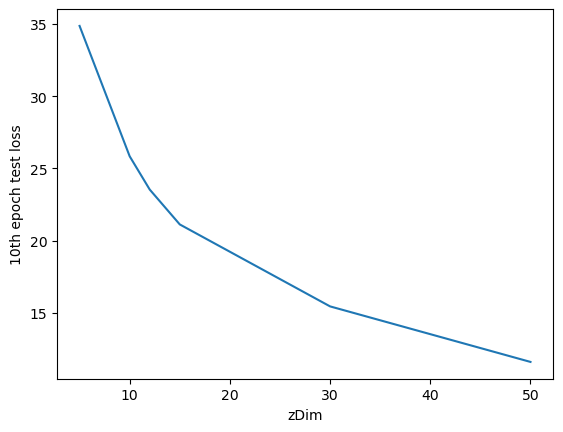

In [22]:
plt.plot(zdims, test_loss[:,9])
    
plt.ylabel("10th epoch test loss"); plt.xlabel("zDim");

## Linear Methods

In [ ]:
"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 10
lin_test_loss = np.zeros(10)

"""
Initialize the network and the Adam optimizer
"""
net = Lin_AE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    print('EPOCH %d' % (epoch))
    running_loss = 0
    last_loss = 0
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out = net(imgs)
        loss = loss_fn(out, imgs)
        
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Gather data and report
        running_loss += loss
        if idx % 500 == 499:
            last_loss = running_loss/500
            print(" Batch %d | loss: %.4f" % (idx, last_loss))
            running_loss = 0
        
    print()
    # test error
    running_tloss = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print("\r" + str(i), end="")
            imgs, _ = data
            imgs = imgs.to(device)
            
            out = net(imgs)
            tloss = loss_fn(out, imgs)
            running_tloss += tloss
        
    avg_vloss = running_tloss/(i+1)
    lin_test_loss[epoch] = avg_vloss
    
    print("\nLOSS | train: %.4f | test %.4f" % (last_loss, avg_vloss))

In [62]:
# convert datasets to numpy
train_loader = DataLoader(train_split, batch_size=len(train_loader.dataset), shuffle=True)
test_loader = DataLoader(test_split, batch_size=len(test_loader.dataset), shuffle=True)

for batch in train_loader:
    train_data = batch
    
for batch in test_loader:
    test_data = batch
    
train_data = np.array(train_data[0])
test_data = np.array(test_data[0])

In [68]:
train_data = train_data.reshape(-1, 320)
test_data = test_data.reshape(-1, 320)

In [69]:
train_data.shape

(160446, 320)

In [100]:
pca = PCA(n_components=15)
pca.fit(train_data)

PCA(n_components=15)

In [101]:
test_pca = pca.transform(test_data)
test_rec = pca.inverse_transform(test_pca)

In [102]:
test_rec = torch.from_numpy(test_rec)
# test_data = torch.from_numpy(test_data)

In [103]:
pca_loss = [int(loss_fn(test_rec, test_data))]

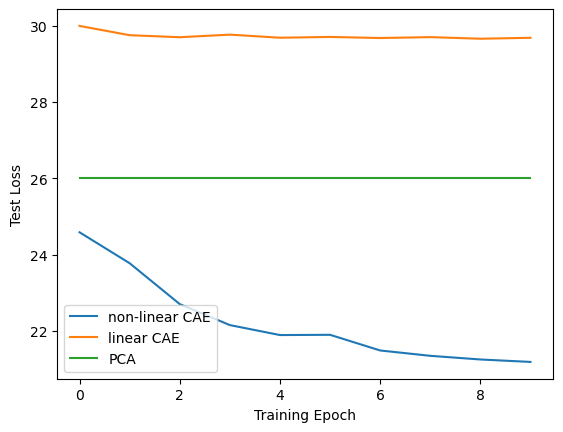

In [107]:
plt.plot(test_loss, label="non-linear CAE")
plt.plot(lin_test_loss, label="linear CAE")
plt.plot(pca_loss*10, label="PCA");
plt.legend(); plt.xlabel("Training Epoch"); plt.ylabel("Test Loss");
